# ☕️ 스타벅스 고객 데이터를 활용한 고객 세분화 프로젝트
- 🔎 데이터 설명
  - 스타벅스에서 고객들을 대상으로 1개월간 진행된 프로모션(offer)에 대한 고객 반응 데이터입니다. 3가지 테이블로 구성됩니다.
- 🤔 목표
  - 데이터로부터 고객 행동 관련 특징을 추출하거나 추가적으로 생성하여 고객을 군집화합니다.
  - 이를 통해 회사의 수익성을 높일 수 있는 고객군별 마케팅 전략에 대한 방향성을 제공하고자 합니다.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'AppleGothic'

In [2]:
# 3가지 테이블
offers = pd.read_csv('./data/portfolio.csv', index_col=0)
customers = pd.read_csv('./data/profile.csv', index_col=0)
transcripts = pd.read_csv('./data/transcript.csv', index_col=0)

## 1. 데이터 전처리

### 1-1. 데이터 Cleaning

In [3]:
offers.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
customers.head()

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcripts.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## 1. 데이터 전처리

### 1-1. 데이터 Cleaning

In [6]:
# offers 데이터 결측값 확인
offers.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
# customers 데이터 결측값 확인
customers.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [8]:
# customers 데이터 결측값 탐구
# gender과 income 컬럼의 결측값은 동일한 레코드에 존재한다.
customers_gender_na = customers[customers['gender'].isna()]
customers_income_na = customers[customers['income'].isna()]

np.sum(customers_gender_na['id'] == customers_income_na['id']) == 2175

True

In [9]:
# '고객별 income' → '고객 behavior'에 영향을 끼친다고 가정
# 따라서 customers 테이블에서 income 컬럼의 값이 결측값인 레코드는 삭제
ids_to_remove = customers_income_na['id']
customers = customers[~customers['id'].isin(ids_to_remove)]
customers.reset_index(drop=True, inplace=True)

# customers 테이블의 총 레코드 수는 14825개
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [10]:
customers['became_member_on'] = pd.to_datetime(customers['became_member_on'], format='%Y%m%d')
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   id                14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 579.2+ KB


In [11]:
customers.head()

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [12]:
# transcripts 데이터 결측값 확인
transcripts.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [13]:
transcripts.rename(
  columns={'time': 'hours_since_start'},
  inplace=True)

transcripts.columns

Index(['person', 'event', 'value', 'hours_since_start'], dtype='object')

### 1-2. 데이터 변환

In [14]:
# offers 테이블의 각 레코드에 별칭 부여
from string import ascii_uppercase

offers = (
  offers
  .sort_values(by=['offer_type', 'difficulty'])
  .reset_index(drop=True))

offers['offer_alias'] = [ascii_uppercase[i] for i in range(offers.shape[0])]
offers.head()

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,A
1,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,B
2,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,C
3,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E


In [15]:
value_col = transcripts['value']
value_col = value_col.apply(eval)

value_col[:3]

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
Name: value, dtype: object

In [16]:
dict_key_col = [list(dic.keys())[0] for dic in value_col]
dict_val_col = [list(dic.values())[0] for dic in value_col]

value_col_split = pd.DataFrame(columns=['dict_key', 'dict_value'])
value_col_split['dict_key'] = dict_key_col
value_col_split['dict_value'] = dict_val_col

value_col_split.head(2)

,dict_key,dict_value
0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [17]:
transcripts = transcripts.drop('value', axis=1)
transcripts = pd.concat([transcripts, value_col_split], axis=1)

col_orders = ['person', 'event', 'dict_key', 'dict_value', 'hours_since_start']
transcripts = transcripts[col_orders]

transcripts.sample(3)

,person,event,dict_key,dict_value,hours_since_start
59557,bd69af886bf2416ea1866d47e6305802,offer received,offer id,2906b810c7d4411798c6938adc9daaa5,168
214163,2b9476ff747d4974af5679ac8485e5f2,offer received,offer id,ae264e3637204a6fb9bb56bc8210ddfd,504
80995,7c0407a5b3bb4ea39bf1291e59682da5,transaction,amount,15.98,198


## 2. EDA

### 2-1. customers 테이블

In [18]:
customers.head(3)

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0


#### 2-1-1. 일변량 분석

##### 성별

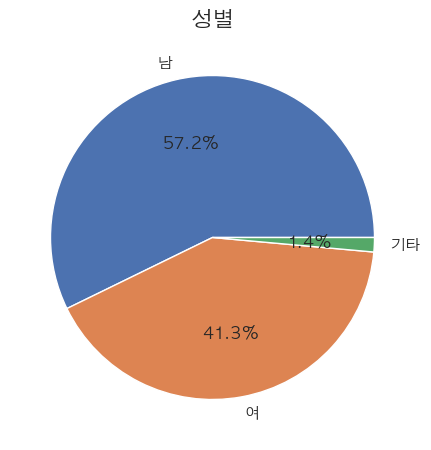

In [19]:
wedge_size = customers['gender'].value_counts()
wedge_labels = ['남', '여', '기타']

plt.figure(figsize=(5, 5))
plt.pie(
  x=wedge_size,
  labels=wedge_labels,
  autopct='%1.1f%%')
plt.title('성별', fontsize=16)
plt.show()

##### 연령
1. 고객 중 최소 연령은 18세, 최대 연령은 101세라는 사실을 알 수 있다.
2. 고객 연령의 분포가 대략적으로 평균이 54, 표준편차가 17인 정규분포를 따른다는 사실을 알 수 있다.
3. 고객이 가장 많은 연령대는 56-65세, 46-55세, 66-75세 순이라는 사실을 알 수 있다. 이처럼 TOP3 그룹은 전체 고객의 약 60%를 차지한다.
4. 🔥 연령이 고객 구매 행동과 offer에 대한 반응에 어떤 영향을 미치는지 알아보자!

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


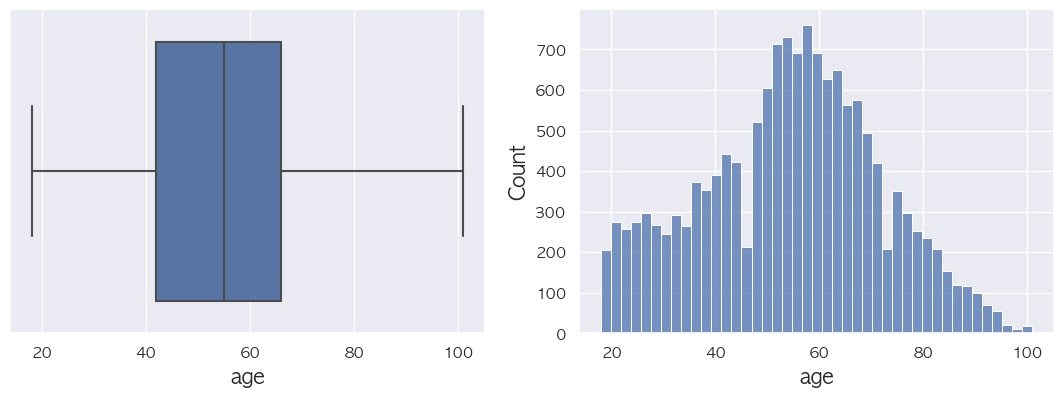

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(
  data=customers,
  x='age',
  ax=axes[0])

sns.histplot(
  data=customers,
  x='age',
  ax=axes[1])

axes[0].xaxis.label.set_size(15)
axes[1].xaxis.label.set_size(15)
axes[1].yaxis.label.set_size(15)

print(customers['age'].describe())

In [21]:
# 연령대별 그룹
age_group = (
  pd.cut(
    customers['age'],
    bins = [customers['age'].min(), 26, 36, 46, 56, 66, 76, 86, customers['age'].max()],
    labels = ['18-25yrs', '26-35yrs', '36-45yrs', '46-55yrs', '56-65yrs', '66-75yrs', '76-85yrs', '> 86yrs']))
customers['age_group'] = age_group

In [22]:
age_group_pct = (
  customers
    .value_counts('age_group')
    .sort_index())
age_group_pct = (age_group_pct / customers.shape[0] * 100).round(1)

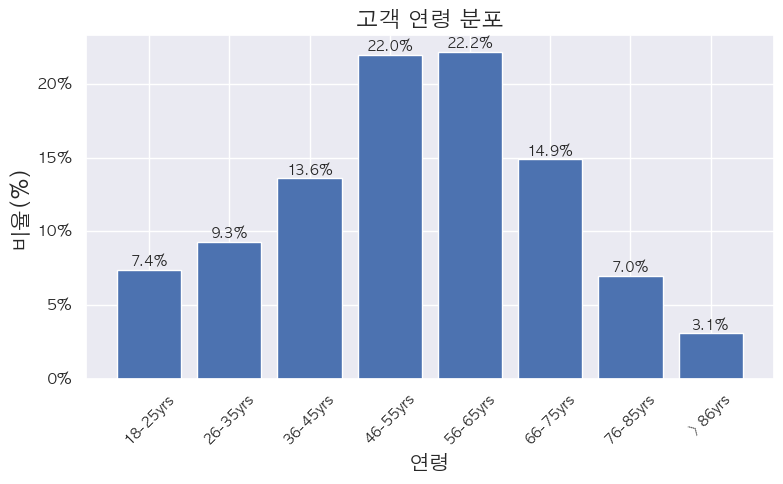

In [23]:
plt.figure(figsize=(8, 5))
yticks = np.arange(0, 25, 5)
ytick_labels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = ytick_labels)
plt.xticks(rotation = 45, fontsize = 10)
plt.xlabel('연령', fontsize = 15)
plt.ylabel('비율(%)', fontsize = 15)
plt.title('고객 연령 분포', fontsize = 16)

bar_plot = plt.bar(x = age_group_pct.index.values, height = age_group_pct)

for idx, bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(
      x + bar.get_width() / 2, y + bar.get_height() + .2,
      str(age_group_pct[idx]) + '%',
      ha='center',
      weight='bold',
      size='small')

plt.tight_layout()
plt.show()

##### 수입
1. 고객 수입 데이터의 분포는 $30,000 ~ $120,000이고, 평균 수입이 $65,400라는 사실을 알 수 있다.
2. TOP2 수입대는 $60-75K, $45-60k라는 사실을 알 수 있다. 이는 전체 고객의 50%에 해당하는 수치다.
3. 🔎 존재하지 않는 수입대 구간? 카페를 방문할 여유가 없거나 카페를 방문하지 않고 다른 방식으로 시간을 보낸다는 사실을 유추해볼 수 있다.
4. 🔥 수입이 지출과 offer에 대한 반응에 어떤 영향을 미치는지 알아보자!

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


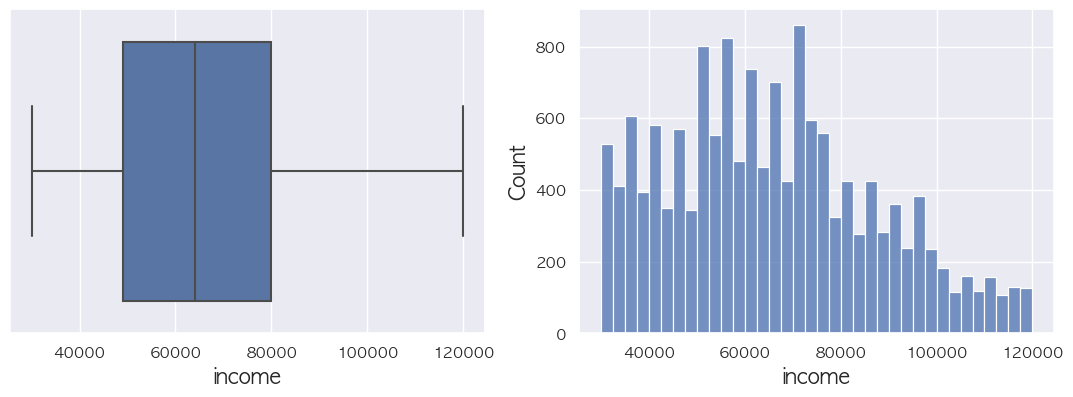

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(
  data=customers,
  x='income',
  ax=axes[0])

sns.histplot(
  data=customers,
  x='income',
  ax=axes[1])

axes[0].xaxis.label.set_size(15)
axes[1].xaxis.label.set_size(15)
axes[1].yaxis.label.set_size(15)

print(customers['income'].describe())

In [25]:
# 수입대별 그룹
income_group = (
  pd.cut(
    customers['income'],
    bins = [customers['income'].min(), 45000, 60000, 75000, 90000, 105000, customers['income'].max()],
    labels = ['$30-45k', '$45-60k', '$60-75k', '$75-90k', '$90-105k', '> $105k']))
customers['income_group'] = income_group

In [26]:
income_group_pct = (
  customers
    .value_counts('income_group')
    .sort_index())
income_group_pct = (income_group_pct / customers.shape[0] * 100).round(1)

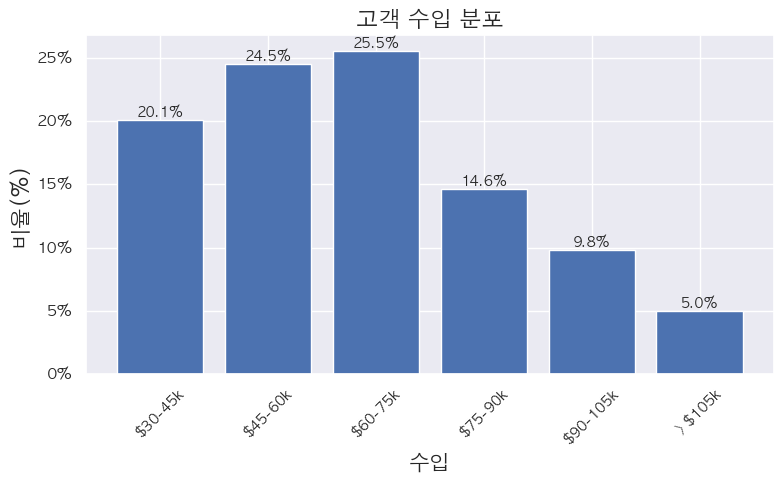

In [27]:
plt.figure(figsize=(8, 5))
yticks = np.arange(0, 30, 5)
ytick_labels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = ytick_labels)
plt.xticks(rotation = 45, fontsize = 10)
plt.xlabel('수입', fontsize = 15)
plt.ylabel('비율(%)', fontsize = 15)
plt.title('고객 수입 분포', fontsize = 16)

bar_plot = plt.bar(x = income_group_pct.index.values, height = income_group_pct)

for idx, bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(
      x + bar.get_width() / 2, y + bar.get_height() + .2,
      str(income_group_pct[idx]) + '%',
      ha='center',
      weight='bold',
      size='small')

plt.tight_layout()
plt.show()

##### 멤버십 가입일
1. 신규 가입자 수 TOP3 월은 8월-10월-12월 순이라는 사실을 알 수 있다.
2. 2월 신규 가입자 수가 상대적으로 적은 사실을 알 수 있다.
3. 평일보다 주말 신규 가입자 수가 상대적으로 더 많다는 사실을 알 수 있다.
4. 금요일에 신규 가입자 수가 상대적으로 적다는 사실을 알 수 있다.

In [28]:
memberships = customers[['id', 'became_member_on']]

# 멤버십 가입일을 연, 월, 일, 요일로 나누기
memberships = (
  memberships.assign(
    year = memberships['became_member_on'].dt.year,
    month = memberships['became_member_on'].dt.month,
    day = memberships['became_member_on'].dt.day,
    month_name = memberships['became_member_on'].dt.month_name(),
    day_of_week = memberships['became_member_on'].dt.weekday,
    day_name = memberships['became_member_on'].dt.day_name()))

memberships.head(2)

,id,became_member_on,year,month,day,month_name,day_of_week,day_name
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,7,15,July,5,Saturday
1,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,2017,5,9,May,1,Tuesday


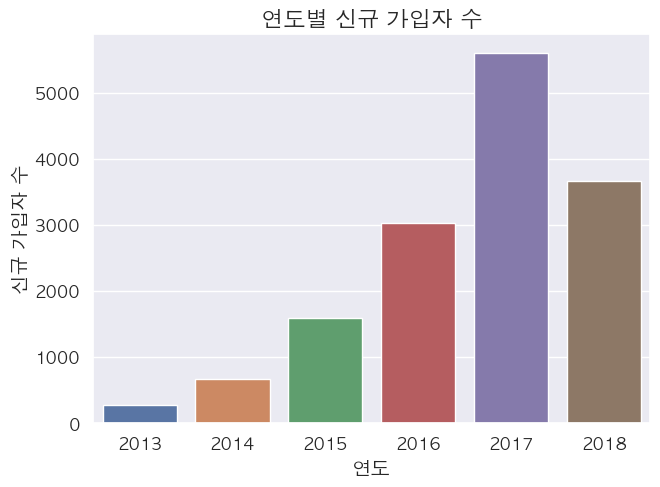

In [29]:
# 연도별 신규 가입자 수
sns.countplot(data=memberships, x='year')
plt.title('연도별 신규 가입자 수', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('연도', fontsize = 14)
plt.ylabel('신규 가입자 수', fontsize = 14)
plt.show();

In [30]:
time_series = (
  memberships
    .value_counts('became_member_on')
    .sort_index())

df_member_growth = (
  pd.DataFrame(
    index = time_series.index.values,
    data = time_series.values,
    columns = ['신규 가입자 수']))

In [31]:
phase_1 = df_member_growth.loc['2013-july' : '2015-july']
len_phase_1 = phase_1.shape[0]
mean_phase_1 = phase_1.mean().values

phase_2 = df_member_growth.loc['2015-august' : '2017-july']
len_phase_2 = phase_2.shape[0]
mean_phase_2 = phase_2.mean().values

phase_3 = df_member_growth.loc['2017-august' : '2018-jan']
len_phase_3 = phase_3.shape[0]
mean_phase_3 = phase_3.mean().values

phase_4 = df_member_growth.loc['2018-feb' : '2018-july']
len_phase_4 = phase_4.shape[0]
mean_phase_4 = phase_4.mean().values

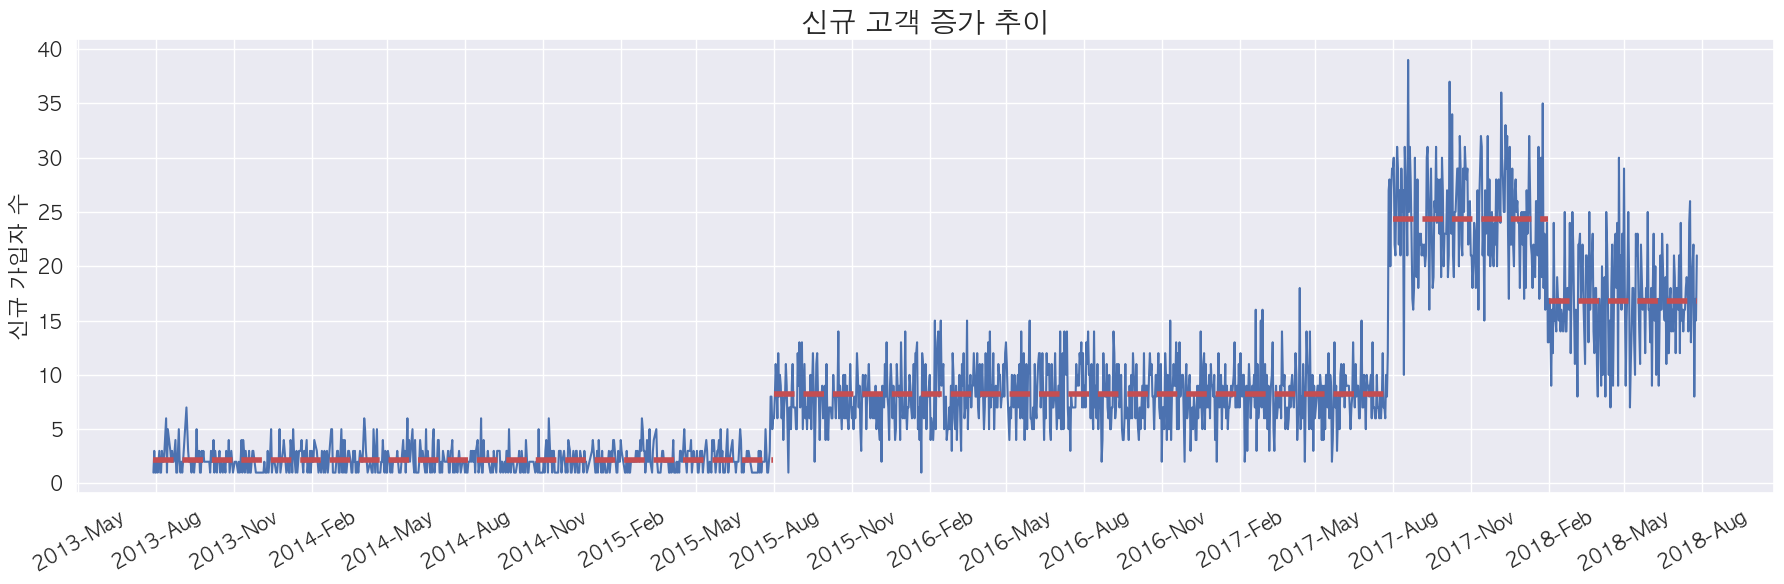

In [32]:
plt.figure(figsize=(18, 6))
ax = (
  sns.lineplot(
    x = df_member_growth.index.values,
    y = df_member_growth['신규 가입자 수']))
date_format = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.plot(phase_1.index.values, np.ones(len_phase_1)*mean_phase_1, '--r', linewidth = 4)
plt.plot(phase_2.index.values, np.ones(len_phase_2)*mean_phase_2, '--r', linewidth = 4)
plt.plot(phase_3.index.values, np.ones(len_phase_3)*mean_phase_3, '--r', linewidth = 4)
plt.plot(phase_4.index.values, np.ones(len_phase_4)*mean_phase_4, '--r', linewidth = 4)

plt.xticks(text=ax.xaxis.get_label(), fontsize=14, rotation=30)
plt.yticks(text=ax.yaxis.get_label(), fontsize=14)
plt.ylabel('신규 가입자 수', fontsize=16)
plt.title('신규 고객 증가 추이', fontsize=20)

plt.tight_layout()
plt.show();

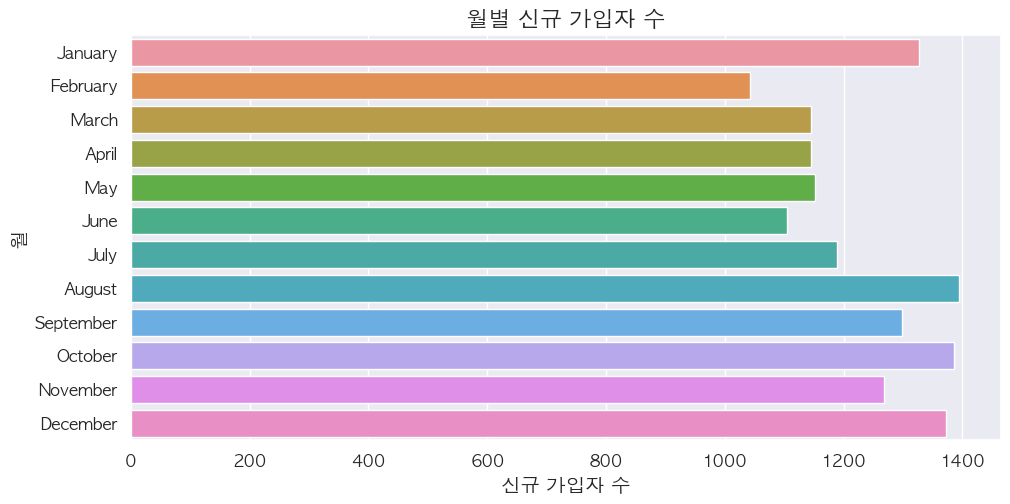

In [33]:
# 월별 신규 가입자 수
plt.figure(figsize=(10, 5))
sns.countplot(
  data=memberships.sort_values('month')
  , y='month_name')
plt.title('월별 신규 가입자 수', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('신규 가입자 수', fontsize=14)
plt.ylabel('월', fontsize=14)
plt.show();

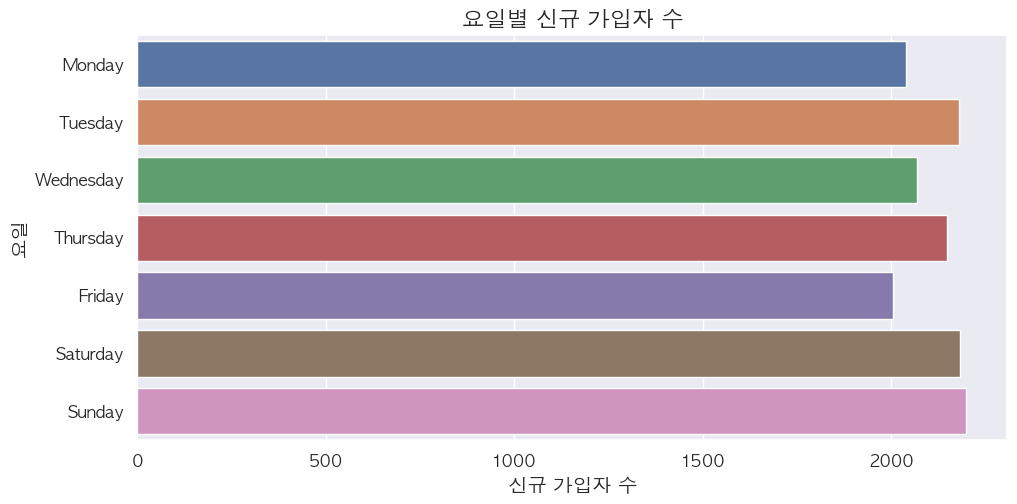

In [34]:
# 요일별 신규 가입자 수
plt.figure(figsize=(10,5))
sns.countplot(
  data=memberships.sort_values('day_of_week'),
  y='day_name')
plt.title('요일별 신규 가입자 수', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('신규 가입자 수', fontsize=14)
plt.ylabel('요일', fontsize=14)
plt.show();

#### 2-1-2. 이변량 분석

##### 성별 - 연령
1. 남녀 고객의 분포는 대략적으로 정규분포를 따른다는 사실을 시각적으로 확인할 수 있다.
2. 젊은 연령대에 속하는 남성 고객이 같은 연령대에 속하는 여성 고객보다 상대적으로 많다는 사실을 알 수 있다.

              age
gender           
F       57.544950
M       52.116690
O       54.400943


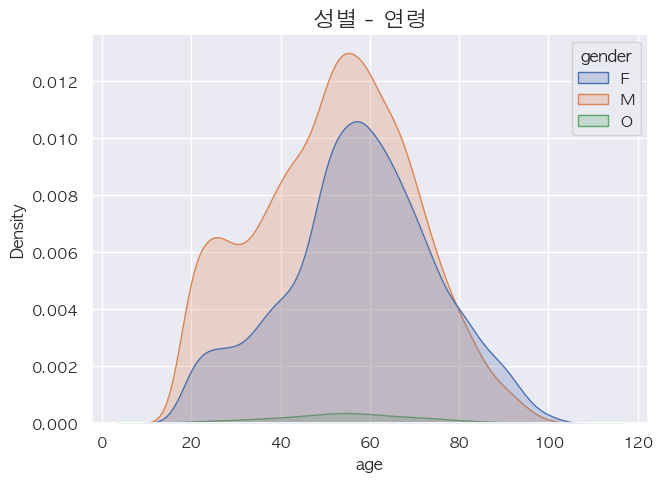

In [35]:
print(
  customers
    .groupby('gender')
    .agg({'age': 'mean'}))

sns.kdeplot(
  data=customers,
  x='age',
  hue='gender',
  fill=True)

plt.title('성별 - 연령', fontsize=16)
plt.show();

##### 성별 - 수입
1. 여성 고객들의 평균 수입이 남성 고객들의 평균 수입보다 높다는 사실을 알 수 있다.
2. 이는 (이전에 살펴본 바와 같이) 여성 고객들보다 남성 고객들의 연령대가 더 낮다는 사실을 통해 짐작할 수 있다.
3. 🔥 연령이 수입에 미치는 영향을 알아보자!

              income
gender              
F       71306.412139
M       61194.601603
O       63287.735849


/Users/jason/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


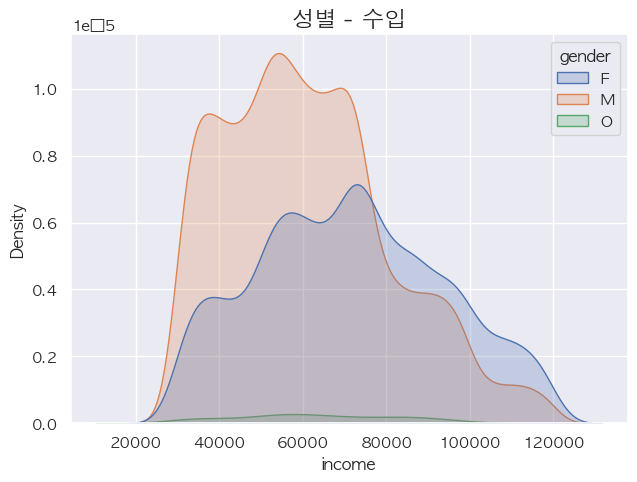

In [36]:
print(
  customers
    .groupby('gender')
    .agg({'income': 'mean'}))

sns.kdeplot(
  data=customers,
  x='income',
  hue='gender',
  fill=True)

plt.title('성별 - 수입', fontsize = 16)
plt.show();

##### 연령 - 수입
1. 18-35세 연령대에 속하는 고객들의 평균 수입은 $51,000라는 사실을 알 수 있다. 36-55세 연령대에 속하는 고객들의 평균 수입은 약 $65,000라는 사실을 알 수 있고, 마지막으로 56세 이상 고객들의 평균 수입은 약 $70,000라는 사실을 알 수 있다.
2. ✅ 이를 통해 연령대가 높을수록 수입 또한 많다는 사실을 알 수 있다.

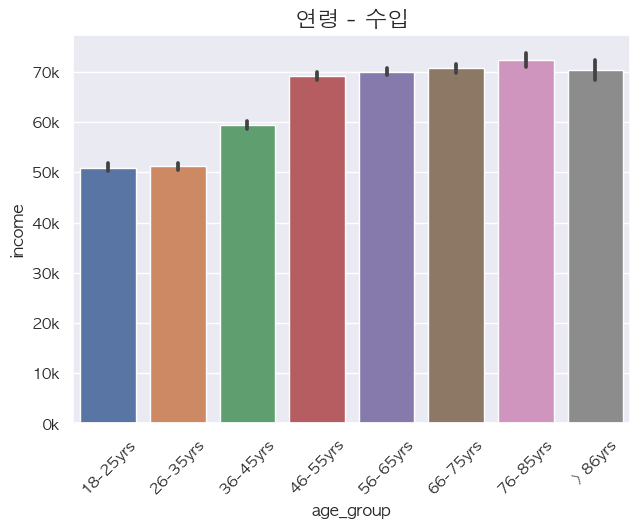

In [37]:
sns.barplot(
  data=customers,
  x='age_group',
  y='income')
plt.xticks(rotation=45)
ytick_labels = [str(i) + 'k' for i in (np.arange(0, 80000, 10000) / 1000).astype(int)]
plt.yticks(np.arange(0, 80000, 10000), labels = ytick_labels)
plt.title('연령 - 수입', fontsize = 16)
plt.show();

### 2-2. offers 테이블

In [38]:
offers

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,A
1,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,B
2,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,C
3,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E
5,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,F
6,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,G
7,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,H
8,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,I
9,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,J


In [39]:
# 수치형 변수(3개), 범주형 변수(2개)
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reward       10 non-null     int64 
 1   channels     10 non-null     object
 2   difficulty   10 non-null     int64 
 3   duration     10 non-null     int64 
 4   offer_type   10 non-null     object
 5   id           10 non-null     object
 6   offer_alias  10 non-null     object
dtypes: int64(3), object(4)
memory usage: 688.0+ bytes


#### 2-2-1. 수치형 변수 Pair Plot
1. 수치형 변수: reward, difficulty, duration
2. Pair Plot으로부터는 가시적인 인사이트를 뽑아낼 수 없다고 판단.

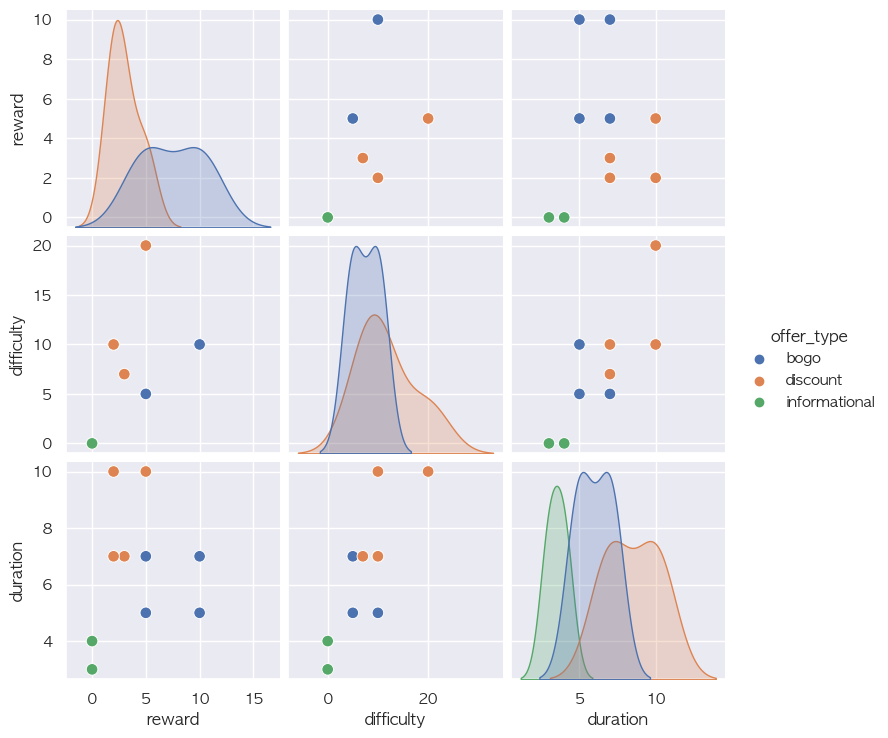

In [40]:
sns.pairplot(
  data=offers,
  hue='offer_type',
  plot_kws=dict(marker='o', s=70))

plt.show();

#### 2-2-2. 일변량 분석

##### 채널
1. 채널별로 offer의 효과를 따져볼 수 있다 → ex. SNS(social)의 효과


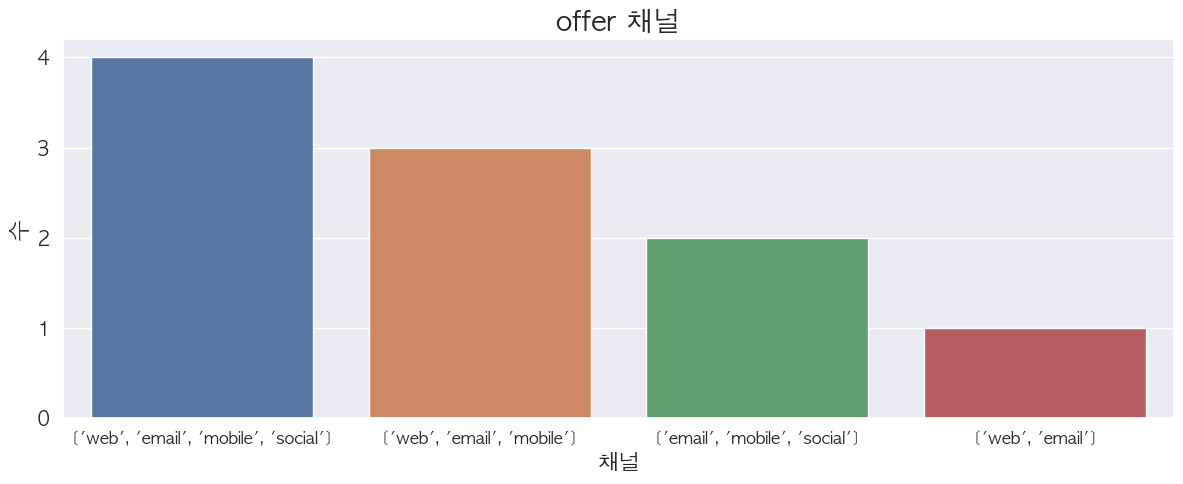

In [41]:
offers_channel_cnts = offers.value_counts('channels')

plt.figure(figsize=(12,5))
sns.barplot(
  x=offers_channel_cnts.index.values,
  y=offers_channel_cnts.values)
plt.xticks(rotation=None, fontsize=12)
plt.yticks(np.arange(5), fontsize=14)
plt.xlabel('채널', fontsize=16, fontweight='bold')
plt.ylabel('수', fontsize=16, fontweight='bold')
plt.title('offer 채널', fontsize=20)

plt.tight_layout()
plt.show();

#### 2-2-3. 이변량 분석
1. 3가지 수치형 변수에 대한 회귀분석 진행

/Users/jason/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


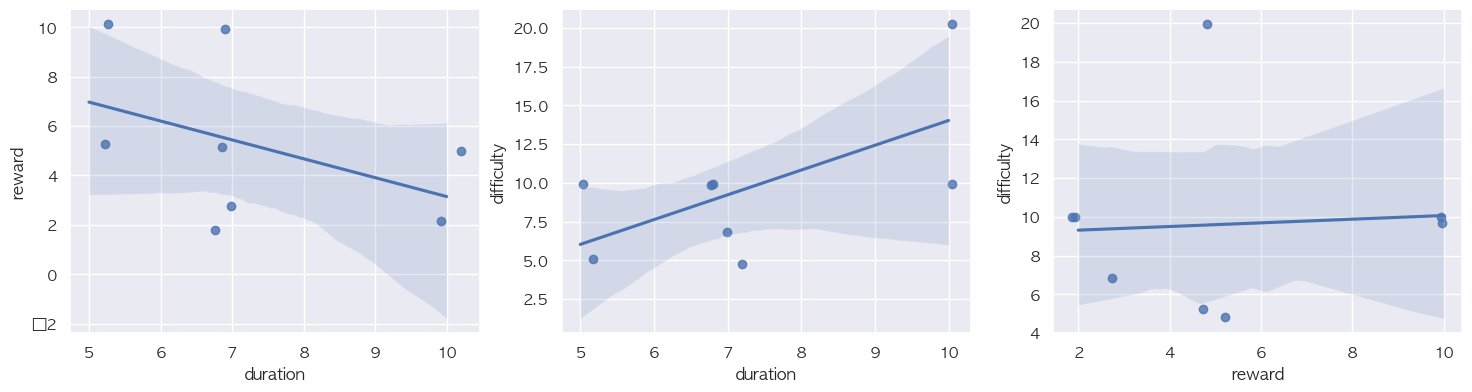

In [42]:
fig, axes = plt.subplots(1,3, figsize = (16,4))

sns.regplot(data=offers[0:8], x='duration', y='reward', x_jitter=0.3, y_jitter=0.3, ax=axes[0])
sns.regplot(data=offers[0:8], x='duration', y='difficulty', x_jitter=0.3, y_jitter=0.3, ax=axes[1])
sns.regplot(data=offers[0:8], x='reward', y='difficulty', x_jitter=0.3, y_jitter=0.3, ax=axes[2])

plt.show();

### 2-3. transcripts 테이블

In [43]:
transcripts.head()

,person,event,dict_key,dict_value,hours_since_start
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,offer id,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,offer id,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,0


#### 2-3-1. 일변량 분석

##### 이벤트
1. 'transaction(실구매)' 건수 = 약 14만건 = 'offer completed' 건수의 약 4배 이상에 해당하는 수치
2. 추가적인 오퍼 없이도 2회 이상의 구매(기존 offer에 대한 구매 포함)가 발생했다는 사실을 알 수 있다. 하지만 이는 식음료를 판매하는 특성상(FMCG; Fast-Moving Customer Goods)당연하다고 볼 수 있다.
3. 'offer received' 중 'offer viewed'의 비율은 약 76%이다. 꽤 높은 View Rate라고 볼 수 있다. 이는 활발한 고객 활동을 의미할 수도 있으며 offer 내용의 문구가 고객들의 관심을 끌었다고 볼 수도 있다.
4. 'offer completed' 건수는 'offer received'의 약 58%, 'offer viewed'의 약 44%에 해당한다. 고객 충성도가 높다고 판단할 수 있다.

In [44]:
print(transcripts.shape)

transcripts.value_counts('event', ascending=False)

(306534, 5)


event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

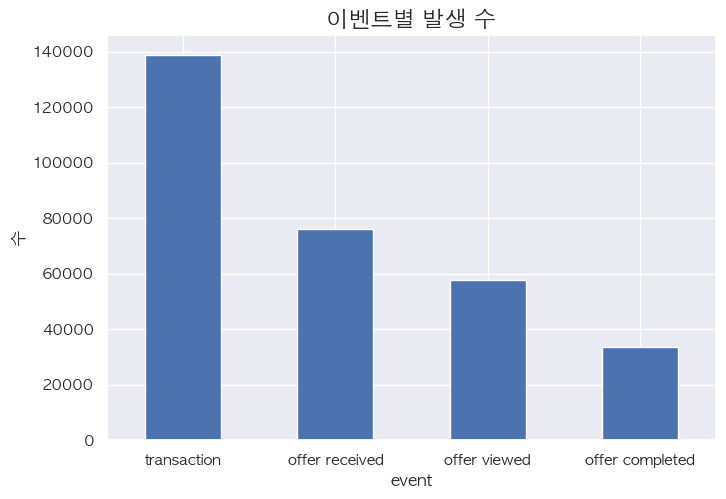

In [45]:
fig = plt.figure(figsize=(7, 5))
(
  transcripts['event']
    .value_counts()
    .plot(kind='bar')
)
plt.xticks(rotation=None)
plt.ylabel('수')
plt.title('이벤트별 발생 수', fontsize=16)

plt.show();

In [46]:
# 이벤트 시작일(0), 이벤트 마지막일(29) → 총 30일
transcripts = (
  transcripts
    .assign(days_since_start = transcripts['hours_since_start'] / 24)
    .astype({'days_since_start': 'int64'}))

print(
  'days_since_start 컬럼의 최소값과 최대값은 각각 {} and {}입니다.'
    .format(
      transcripts['days_since_start'].min(),
      transcripts['days_since_start'].max()))

days_since_start 컬럼의 최소값과 최대값은 각각 0 and 29입니다.


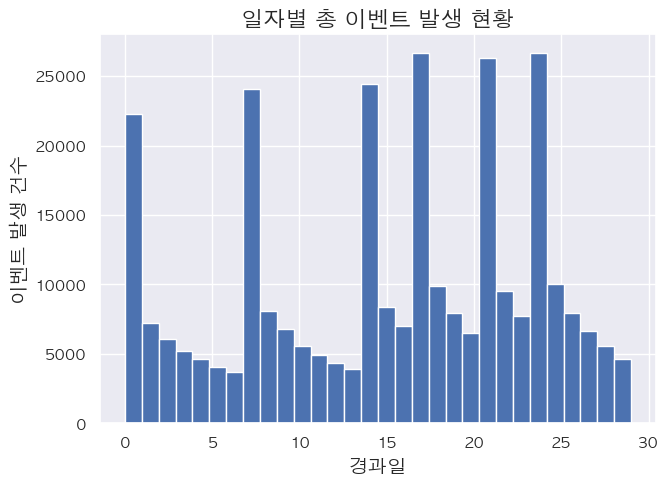

In [47]:
# 이벤트 발생 건수가 급증한 날은 총 6일.
# 🔎 '고객들이 이벤트를 수신(offers received)한 날 아닐까?'와 같은 추측을 해볼 수 있다.
plt.hist(transcripts['days_since_start'], bins=30)
plt.xlabel('경과일', fontsize=14)
plt.ylabel('이벤트 발생 건수', fontsize=14)
plt.title('일자별 총 이벤트 발생 현황', fontsize=16)
plt.show();

In [48]:
# 이벤트 발생 건수가 급증한 6일에 대한 가설 검증 완료
(
  transcripts[transcripts['event'] == 'offer received']
    .groupby('days_since_start')
    .count()
)

,person,event,dict_key,dict_value,hours_since_start
days_since_start,,,,,
0,12650,12650,12650,12650,12650
7,12669,12669,12669,12669,12669
14,12711,12711,12711,12711,12711
17,12778,12778,12778,12778,12778
21,12704,12704,12704,12704,12704
24,12765,12765,12765,12765,12765


In [49]:
viewed_hourly = (
  transcripts[transcripts['event'] == 'offer viewed']
    .value_counts('hours_since_start')
    .sort_index())
completed_hourly = (
  transcripts[transcripts['event'] == 'offer completed']
    .value_counts('hours_since_start')
    .sort_index())
transaction_hourly = (
  transcripts[transcripts['event'] == 'transaction']
    .value_counts('hours_since_start')
    .sort_index())

print(
  len(viewed_hourly),
  len(completed_hourly),
  len(transaction_hourly))

120 120 120


In [50]:
print(
  (viewed_hourly.index.values == completed_hourly.index.values).sum(),
  (completed_hourly.index.values == transaction_hourly.index.values).sum()
)

120 120


In [51]:
received_daily = (
  transcripts[transcripts['event'] == 'offer received']
    .value_counts('days_since_start')
    .sort_index())
viewed_daily = (
  transcripts[transcripts['event'] == 'offer viewed']
    .value_counts('days_since_start')
    .sort_index())
completed_daily = (
  transcripts[transcripts['event'] == 'offer completed']
  .value_counts('days_since_start')
  .sort_index())
transaction_daily = (
  transcripts[transcripts['event'] == 'transaction']
  .value_counts('days_since_start')
  .sort_index())

print(
  len(received_daily),
  len(viewed_daily),
  len(completed_daily),
  len(transaction_daily)
)

6 30 30 30


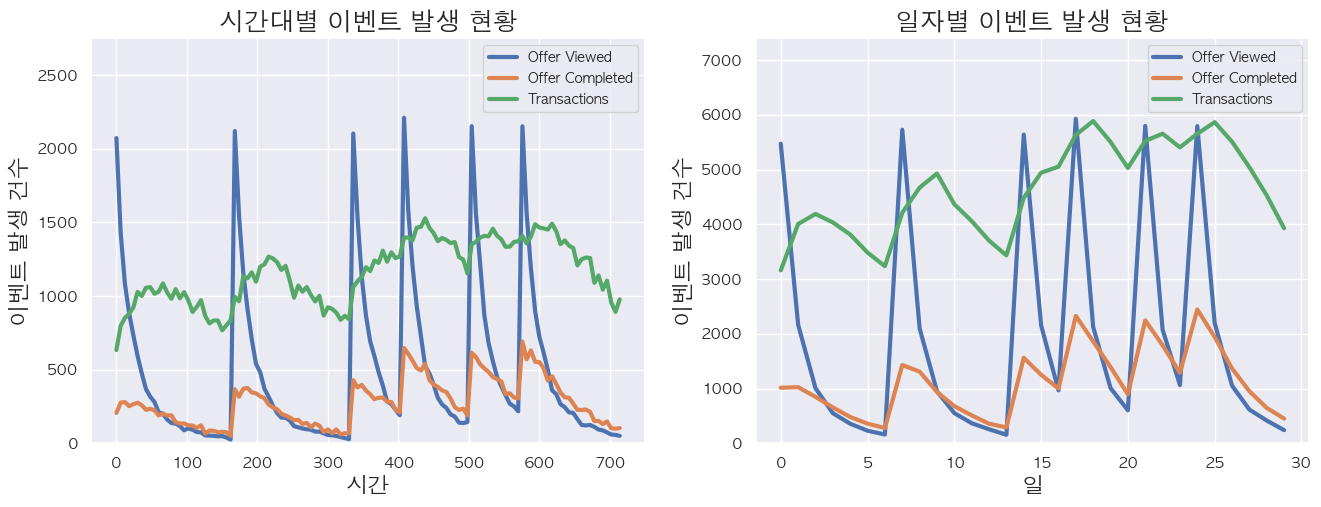

In [52]:
# 시간대별 이벤트 발생 건수 시각화
hours = viewed_hourly.index.values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# axes[0].stem(received_hourly.index.values, received_hourly, linefmt = ':k')
axes[0].plot(hours, viewed_hourly, lw=3)
axes[0].plot(hours, completed_hourly, lw=3)
axes[0].plot(hours, transaction_hourly, lw=3)
axes[0].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc='upper right', ncol=1, fontsize=10)
axes[0].set_ylim([0, 2750])
axes[0].set_xlabel('시간', fontsize=16)
axes[0].set_ylabel('이벤트 발생 건수', fontsize=16)
axes[0].set_title('시간대별 이벤트 발생 현황', fontsize=18)

# 일자별 이벤트 발생 건수 시각화
days = np.arange(30)
# axes[1].stem(received_daily.index.values, received_daily, linefmt = ':k')
axes[1].plot(days, viewed_daily, lw=3)
axes[1].plot(days, completed_daily, lw=3)
axes[1].plot(days, transaction_daily, lw=3)
axes[1].legend(['Offer Viewed', 'Offer Completed', 'Transactions'], loc='upper right', ncol=1, fontsize=10)
axes[1].set_ylim([0, 7400])
axes[1].set_xlabel('일', fontsize=16)
axes[1].set_ylabel('이벤트 발생 건수', fontsize=16)
axes[1].set_title('일자별 이벤트 발생 현황', fontsize=18)

plt.show();

✅ 도출 가능한 인사이트
1. 위 '시간대별/일자별 이벤트 발생 현황' 그래프를 통해서 일회성 Offer는 단기 효과가 있다는 것을 알 수 있다.
2. 따라서 단기적인 Offer, 즉 단기적인 offer 방안에 대해 지속적으로 생각해보는 것도 회사 수익성 측면에서도 좋은 방안이 될 수 있다.

## 3. 🤔 어떤 offer가 가장 인기가 있었을까?
- 인기가 가장 많았던 offer와 그 이유에 대해서 알아봐야 한다.
- '인기가 많다'의 기준?
  - 기준 metrics가 필요하다.
    1. View Rate = 'Offers Viewed' / 'Offers Received'
    2. Completion Rate = 'Offers Completed' / 'Offers Viewed'
- 🔥 알아볼 내용
  1. 어떤 offer가 가장 인기가 있었나?
  2. View Rate에 기여도가 가장 높은 요인은?
  3. Completion Rate에 기여도가 가장 높은 요인은?
- 🤓 인사이트
  1. 사용자들에게 최대한 많은 채널을 통해 프로모션 정보를 전달해야 한다.
  2. 단, 예산이 한정되어 있다면 SNS를 통한 프로모션 홍보가 가장 효과적이다.
  3. 프로모션 주제가 할인 관련이라면 고객들의 관심을 받을 가능성이 높아진다.

### 3-1. 어떤 offer가 가장 인기가 있었나?
- 사용한 metric: overall complete rate(offer completed / offer received)
- ✅ 결론
  1. 4가지 채널을 모두 사용한 offer(F, E, B)가 사용자의 반응이 가장 뜨거웠다.
  2. 단순히 overall complete rate로 보지 않고 2개의 추가 metrics로 쪼개서 확인할 필요가 있다.
    - view rate(offer viewed / offer received)
    - complete rate(offer completed / offer viewed)

In [53]:
# 4가지 이벤트 중 transaction(실구매)는 제외한 이벤트만 필터
events_exclude_trans = transcripts[~(transcripts['event'] == 'transaction')]

events_offer_only = (
  pd
    .merge(
      events_exclude_trans,
      offers,
      left_on='dict_value',
      right_on='id')
    .drop('id', axis=1))

target_cols = ['person', 'event', 'offer_alias', 'reward', 'channels', 'difficulty', 'duration', 'offer_type', 'hours_since_start', 'days_since_start', 'dict_key', 'dict_value',]
events_offer_only = events_offer_only[target_cols]

events_offer_only = events_offer_only.drop('dict_value', axis = 1)
events_offer_only.head(2)

,person,event,offer_alias,reward,channels,difficulty,duration,offer_type,hours_since_start,days_since_start,dict_key
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,A,5,"['web', 'email', 'mobile']",5,7,bogo,0,0,offer id
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,A,5,"['web', 'email', 'mobile']",5,7,bogo,0,0,offer id


In [54]:
# offer_alias를 offer명으로 사용
offers.head()

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,A
1,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,B
2,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,C
3,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,D
4,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E


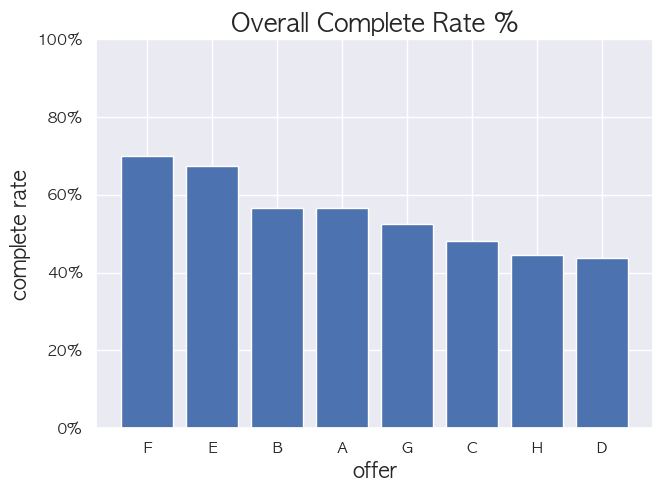

In [55]:
offers_received = events_offer_only[events_offer_only['event'] == 'offer received']
p0 = (
  offers_received
    .value_counts('offer_alias')
    .sort_values(ascending=False))

offers_completed = events_offer_only[events_offer_only['event'] == 'offer completed']
p2 = (
  offers_completed
    .value_counts('offer_alias')
    .sort_values(ascending = False))

overall_complete_rate = (p2.sort_index() / p0.sort_index()).sort_values(ascending=False)

plt.bar(
  x=overall_complete_rate.index.values,
  height = overall_complete_rate.values)
plt.title('Overall Complete Rate %', fontsize=18)
plt.xlabel('offer', fontsize=15)
plt.ylabel('complete rate', fontsize=15)
plt.yticks(
  np.arange(0, 1.2, 0.2),
  labels=['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show();

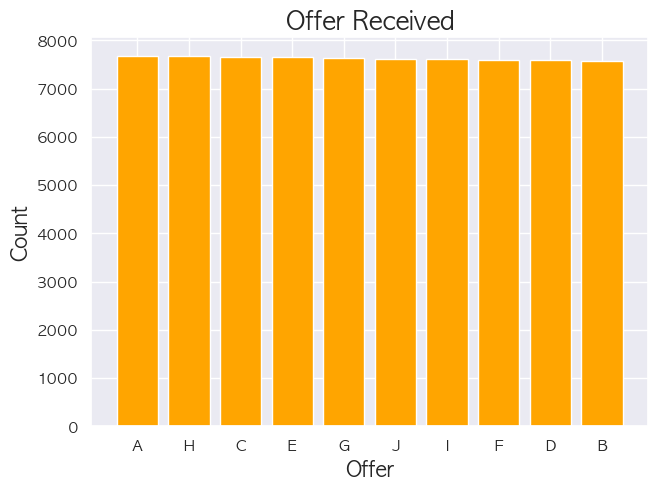

In [56]:
plt.bar(
  x=np.arange(len(p0)),
  height=p0.values,
  tick_label=p0.index.values,
  color='orange')
plt.title('Offer Received', fontsize=18)
plt.xlabel('Offer', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show();

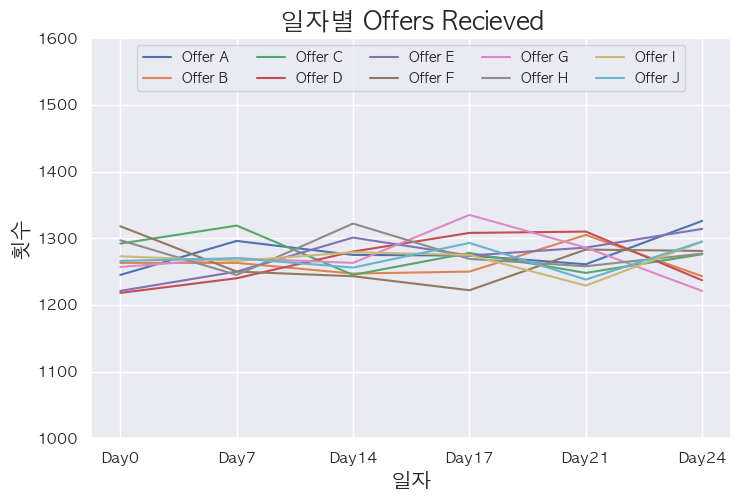

In [57]:
num_offers = len(offers)
each_offer_received = pd.DataFrame(index=received_daily.index.values)

for col in ascii_uppercase[:num_offers]:
  each_offer_received[col] = (
    offers_received[offers_received['offer_alias'] == col]
      .value_counts('days_since_start')
      .sort_index())
each_offer_received.index = ['Day' + str(x) for x in received_daily.index.values]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))

for col in ascii_uppercase[:num_offers]:
  ax.plot(np.arange(6), each_offer_received[col])
    
ax.set_ylim([1000, 1600])
ax.set_xticks(np.arange(6))
ax.set_xticklabels(each_offer_received.index.values)
ax.set_xlabel('일자', fontsize=15)
ax.set_ylabel('횟수', fontsize=15)
legend_str = ['Offer ' + i for i in ascii_uppercase[:num_offers]]
plt.legend(legend_str, loc='upper center', ncol=5, fontsize=10)
plt.title('일자별 Offers Recieved', fontsize=18)
plt.show();

### 3-3. View Rate에 영향을 많이 주는 요소는?
- View Rate = Offers Viewed / Offers Received
- 그룹1(F/D/E/B): email, SNS, mobile, web
- 그룹2(J/C): email, SNS, mobile
- 그룹3(I/A/G): email, mobile, web
- 그룹4(H): email, web
- ✅ 결론
  1. 그룹1 ↔ 그룹2: web. 두 그룹간 view rate의 차이가 크지 않다. 따라서 web의 효과는 상대적으로 미미하다고 볼 수 있다.
  2. 그룹2 ↔ 그룹3: SNS. 두 그룹간 view rate의 차이가 크다. web의 효과는 미미하므로 SNS의 효과가 상대적으로 크다고 볼 수 있다.
  3. 그룹3 ↔ 그룹4: mobile. 
  4. 그룹4: email. web의 효과가 미미하므로 email의 효과가 상대적으로 크다고 볼 수 있다.
  5. SNS > email >= mobile > web 순으로 View Rate에 영향을 미친다는 결론을 내릴 수 있다.

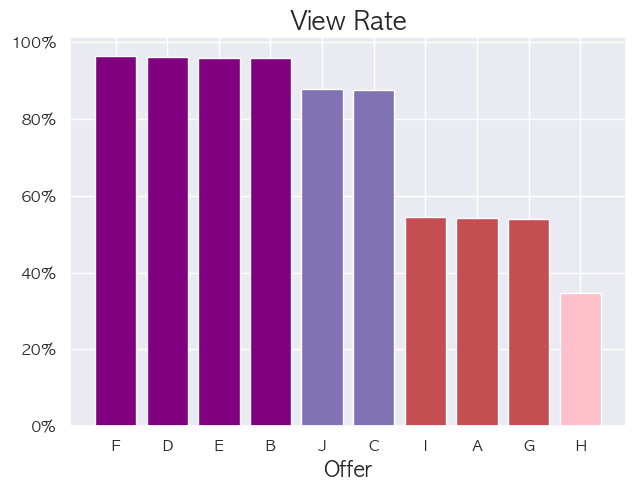

In [58]:
offers_viewed = events_offer_only[events_offer_only['event'] == 'offer viewed']

p1 = (
  offers_viewed
    .value_counts('offer_alias')
    .sort_values(ascending = False))
p1_rate = (p1.sort_index() / p0.sort_index()).sort_values(ascending = False)

plt.bar(
  x=np.arange(len(p1)),
  height=p1_rate.values,
  tick_label=p1_rate.index.values,
  color=['purple', 'purple','purple', 'purple', 'm', 'm','r', 'r', 'r', 'pink'])
plt.title('View Rate', fontsize=18)
plt.xlabel('Offer', fontsize=15)
plt.yticks(np.arange(0, 1.2, 0.2), labels=['0%', '20%', '40%', '60%', '80%', '100%'])
plt.show();

### 3-4. Complete Rate에 영향을 많이 주는 요소는?
- Complete Rate = Offers Completed / Offers Viewed
- 100% 이상의 의미? 1회 이상 Complete
- complete rate가 높다고 view rate가 반드시 높은 것은 아니다. 데이터를 참고하면 오히려 이 두 rate은 반대의 관계에 놓여 있다는 사실을 알 수 있다
- TOP5 중 offer 타입은 discount(H, G, F, E), bogo(A)로 구성되어 있다.
  - 🔥 고객들이 관심있는 것은 할인율! → 할인 관련 프로모션을 단기적으로 자주 진행하는 방안!
- ✅ 결론
  1. 고객들이 가장 관심있어 하는 프로모션은 할인(discount) 관련 행사라는 사실을 알 수 있다.
  2. Discount > BOGO(buy one, get one free)
  3. overall complete rate(offer completed / offer received) 보다 view rate(offer viewed / offer received)와 complete rate(offer completed / offer viewed)로 쪼개서 자세하게 들여다보는 편이 어떤 offer가 고객들의 관심을 끌 수 있는지 자세하게 알 수 있다.

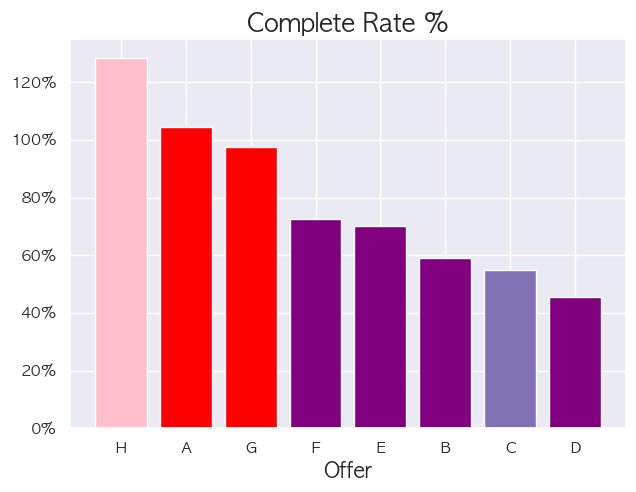

In [59]:
p2 = (
  offers_completed
    .value_counts('offer_alias')
    .sort_values(ascending = False))

p2_rate = (p2.sort_index() / p1.sort_index()).sort_values(ascending=False)
color_list = ['pink', 'red', 'red', 'purple', 'purple', 'purple', 'm', 'purple']
plt.bar(
  x=p2_rate.index.values,
  height=p2_rate.values,
  color=color_list)
plt.title('Complete Rate %', fontsize=18)
plt.xlabel('Offer', fontsize=15)
plt.yticks(np.arange(0, 1.4, 0.2), labels=['0%', '20%', '40%', '60%', '80%', '100%', '120%'])
plt.show();

## 4. 고객 세분화
- 클러스터링에 사용할 피쳐 목록
  1. offer received/viewed/completed 횟수
  2. transactions(실구매) 횟수
  3. 총 지출 금액
- 군집별 해석을 위한 metrics
  1. APV
  2. purchase frequency
  3. overall off complete rate
  4. sensitivity to offers

### 4-1. 고객 행동 관련 특징 추출

In [60]:
id_to_remove = customers_income_na['id']
transcripts_filtered = (
  transcripts[~transcripts['person']
    .isin(id_to_remove)]
  .reset_index(drop = True))

customer_behavior = pd.DataFrame(columns=['person', 'num_received', 'num_viewed', 'num_completed', 'num_transactions', 'money_spent'])
customer_behavior['person'] = (
  transcripts_filtered
    .value_counts('person')
    .sort_index().index.values)

In [61]:
transcripts_filtered = transcripts_filtered.sort_values('person')
transcripts_grouped = transcripts_filtered.groupby(['person', 'event']).count()
transcripts_grouped.head()

dict_key  dict_value  \
person                           event                                   
0009655768c64bdeb2e877511632db8f offer completed         3           3   
                                 offer received          5           5   
                                 offer viewed            4           4   
                                 transaction             8           8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed         3           3   

                                                  hours_since_start  \
person                           event                                
0009655768c64bdeb2e877511632db8f offer completed                  3   
                                 offer received                   5   
                                 offer viewed                     4   
                                 transaction                      8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed                  3   

                                                  days_since_start  
person                           event                              
0009655768c64bdeb2e877511632db8f offer completed                 3  
                                 offer received                  5  
                                 offer viewed                    4  
                                 transaction                     8  
0011e0d4e6b944f998e987f904e8c1e5 offer completed                 3

In [62]:
customer_behavior.set_index('person', inplace=True)

for person_id in customer_behavior.index.values:
    if (person_id, 'offer received') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_received'] = transcripts_grouped.loc[(person_id, 'offer received'), 'dict_key']
    if (person_id, 'offer viewed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_viewed'] = transcripts_grouped.loc[(person_id, 'offer viewed'), 'dict_key']
    if (person_id, 'offer completed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_completed'] = transcripts_grouped.loc[(person_id, 'offer completed'), 'dict_key']
    if (person_id, 'transaction') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_transactions'] = transcripts_grouped.loc[(person_id, 'transaction'), 'dict_key']

In [63]:
money_spent = (
  transcripts_filtered[transcripts_filtered['event'] == 'transaction']
    .groupby('person')
    .agg({'dict_value': 'sum'}))

customer_behavior['money_spent'] = money_spent
customer_behavior.head()

,num_received,num_viewed,num_completed,num_transactions,money_spent
person,,,,,
0009655768c64bdeb2e877511632db8f,5,4,3,8,127.6
0011e0d4e6b944f998e987f904e8c1e5,5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,5,3,3,8,196.86
0020ccbbb6d84e358d3414a3ff76cffd,4,4,3,12,154.05
003d66b6608740288d6cc97a6903f4f0,5,4,3,18,48.34


In [64]:
customer_behavior.isna().sum()

num_received           5
num_viewed           150
num_completed       2839
num_transactions     333
money_spent          333
dtype: int64

In [65]:
# 결측값이 나타나는 이유는 특정 고객들이 특정 항목에 대한 액션을 취하지 않았기 때문이다.
# 따라서 0으로 결측값을 대체한다.
customer_behavior.fillna(0, inplace=True)
customer_behavior.isna().sum()

num_received        0
num_viewed          0
num_completed       0
num_transactions    0
money_spent         0
dtype: int64

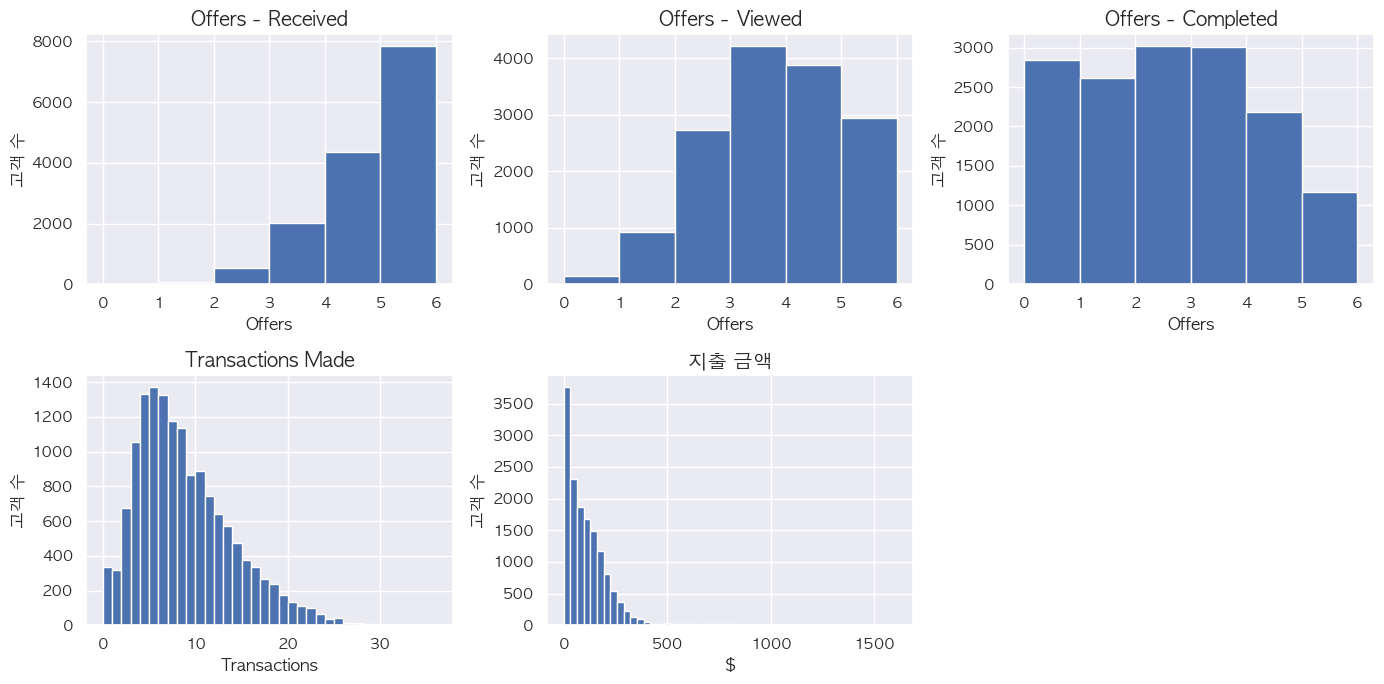

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7))

fig_titles = ['Offers - Received', 'Offers - Viewed', 'Offers - Completed', 'Transactions Made', '지출 금액']
x_labels = ['Offers', 'Offers','Offers','Transactions','$']
y_label = '고객 수'
sub_row, sub_col = 0, 0

for i in range(5):
    if i < 3:
        sub_row = 0
        sub_col = i
        bins = customer_behavior.iloc[:, i].max()
        axes[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins=bins)
        axes[sub_row, sub_col].set_ylabel(y_label, fontsize=12)

    else:
        sub_row = 1
        sub_col = i - 3
        if i == 3:
            bins = customer_behavior.iloc[:, i].max()
            axes[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins=bins)
            axes[sub_row, sub_col].set_ylabel(y_label, fontsize=12)
        else:
            bins = 50
            axes[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins=bins)
            axes[sub_row, sub_col].set_ylabel(y_label, fontsize=12)
    
    axes[sub_row, sub_col].set_title(fig_titles[i], fontsize=14)
    axes[sub_row, sub_col].set_xlabel(x_labels[i], fontsize=12)

axes[1, 2].set_axis_off()
plt.tight_layout()
plt.show();

#### 클러스터링을 위한 본격적인 데이터 변환

In [67]:
# offer received 횟수는 제외한다. 고객들에 의해서 선택된 항목이 아니기 때문이다.
customer_behavior_with_num_received = customer_behavior.copy()

# Drop `num_received`
customer_behavior.drop('num_received', axis=1, inplace=True)
customer_behavior.head(3)

,num_viewed,num_completed,num_transactions,money_spent
person,,,,
0009655768c64bdeb2e877511632db8f,4,3,8,127.60
0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86


In [68]:
# 이상치 제거
# money_spent 데이터가 skewed된 정황이 확인된다.
customer_behavior['money_spent'].describe()

count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: money_spent, dtype: float64

In [69]:
std = customer_behavior['money_spent'].quantile(0.98)

money_spent_2pct = customer_behavior[customer_behavior['money_spent'] >= std]
people_money_spent_2pct = money_spent_2pct.index.values
money_spent_2pct_removed = customer_behavior[customer_behavior['money_spent'] < std]
customer_behavior_filtered = money_spent_2pct_removed.copy()

print('Number of rows removed:', len(money_spent_2pct))

Number of rows removed: 297


### 4-2. K평균 클러스터링
Elbow/Silhouette method를 통해서 군집 수는 5개로 정했다.

In [70]:
scaler_customer_behavior = StandardScaler()
scaler_customer_behavior.fit(customer_behavior_filtered)
customer_behavior_scaled = scaler_customer_behavior.transform(customer_behavior_filtered)

pd.DataFrame(
  data=customer_behavior_scaled,
  columns=customer_behavior_filtered.columns.values).head(3)

,num_viewed,num_completed,num_transactions,money_spent
0,0.501233,0.531352,-0.060069,0.277234
1,1.276977,0.531352,-0.639666,-0.281415
2,-0.274511,0.531352,-0.060069,1.080974


/Users/jason/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jason/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jason/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jason/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

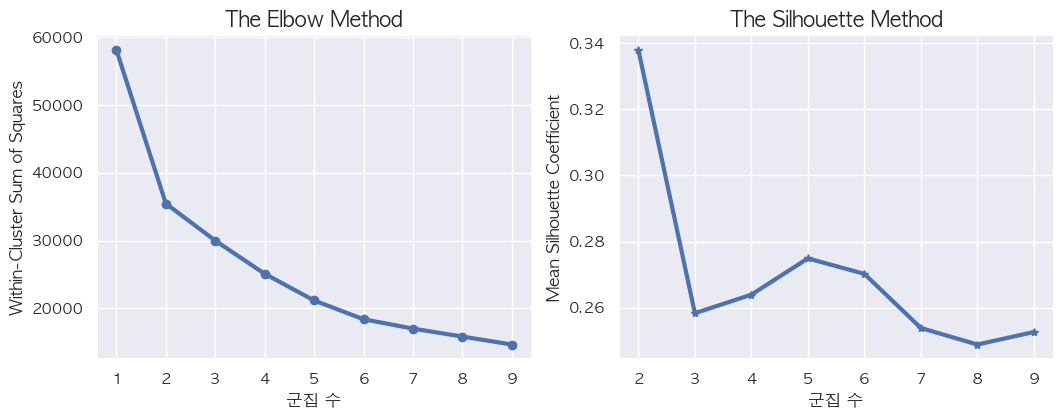

In [71]:
df_feature = customer_behavior_scaled
wcss = []; sil_score = []; max_clusters = 10

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(df_feature)
    wcss.append(kmeans.inertia_)
    
    if k >= 2:
        labels = kmeans.labels_
        sil_score.append(metrics.silhouette_score(df_feature, labels))

fig, axes = plt.subplots(1, 2, figsize=(11,4))
axes[0].plot(np.arange(1, max_clusters), wcss, marker='o', lw=3)
axes[0].set_xlabel('군집 수', fontsize=12)
axes[0].set_ylabel('Within-Cluster Sum of Squares')
axes[0].set_title('The Elbow Method', fontsize=15)

axes[1].plot(np.arange(2, max_clusters), sil_score, marker='*' , lw=3)
axes[1].set_xlabel('군집 수', fontsize=12)
axes[1].set_ylabel('Mean Silhouette Coefficient')
axes[1].set_title('The Silhouette Method', fontsize=15)
plt.show();

/Users/jason/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


cluster
0    2882
1    4029
2    2634
3    3394
4    1589
Name: count, dtype: int64

 ************************************************************
Silhouette 점수: 0.27489368005802256

 ************************************************************
        num_viewed num_completed num_transactions money_spent
              mean          mean             mean        mean
cluster                                                      
0              4.5           4.1             12.2       223.6
1              2.1           0.7              5.0        34.7
2              4.5           1.5              4.5        50.1
3              2.9           2.9              7.7       140.1
4              3.5           2.0             17.1        72.4


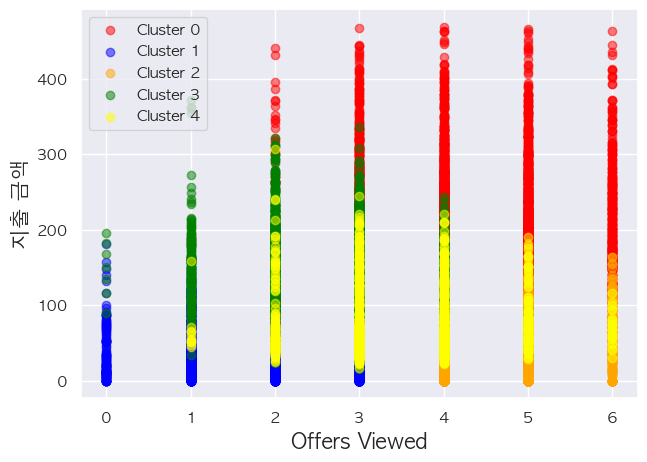

In [72]:
k = 5
df_feature = customer_behavior_scaled
kmeans = KMeans(n_clusters=k, random_state=10)
kmeans.fit_transform(df_feature)
customer_with_cluster = customer_behavior_filtered.assign(cluster=kmeans.labels_)
print(customer_with_cluster.value_counts('cluster').sort_index())

line_sep = '*' * 60
print('\n', line_sep)
print('Silhouette 점수:', metrics.silhouette_score(df_feature, labels=kmeans.labels_))

cluster_info = customer_with_cluster.groupby('cluster').agg([np.mean])
print('\n', line_sep)
print(cluster_info.round(1))

color_list = ['red', 'blue', 'orange', 'green', 'yellow']
legend_list = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
for i in range(k):
  plt.scatter(
    customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'num_viewed'],
    customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'money_spent'],
    c=color_list[i],
    label=legend_list[i],
    alpha=0.5)
plt.ylabel('지출 금액', fontsize=15)
plt.xlabel('Offers Viewed', fontsize=15)
plt.legend(legend_list)
plt.show();

#### 클러스터링 결과 평가

In [73]:
X = customer_behavior_scaled
Y = customer_with_cluster['cluster']
X_train, X_test, Y_train, Y_test = train_test_split(
  X, Y,
  test_size=0.2,
  random_state=10)

In [74]:
# 로지스틱회귀
clf = LogisticRegression()
clf.fit(X_train, Y_train)

y_predict = clf.predict(X_test)
print("Test 정확도: ", metrics.accuracy_score(Y_test, y_predict))

Test 정확도:  0.9948382656572609


In [75]:
# KNN
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, Y_train)

# Check test accuracy
y_predict = knn.predict(X_test)
print("Test 정확도: ", metrics.accuracy_score(Y_test, y_predict))

Test 정확도:  0.9855471438403304


#### 클러스터링 결과 시각화

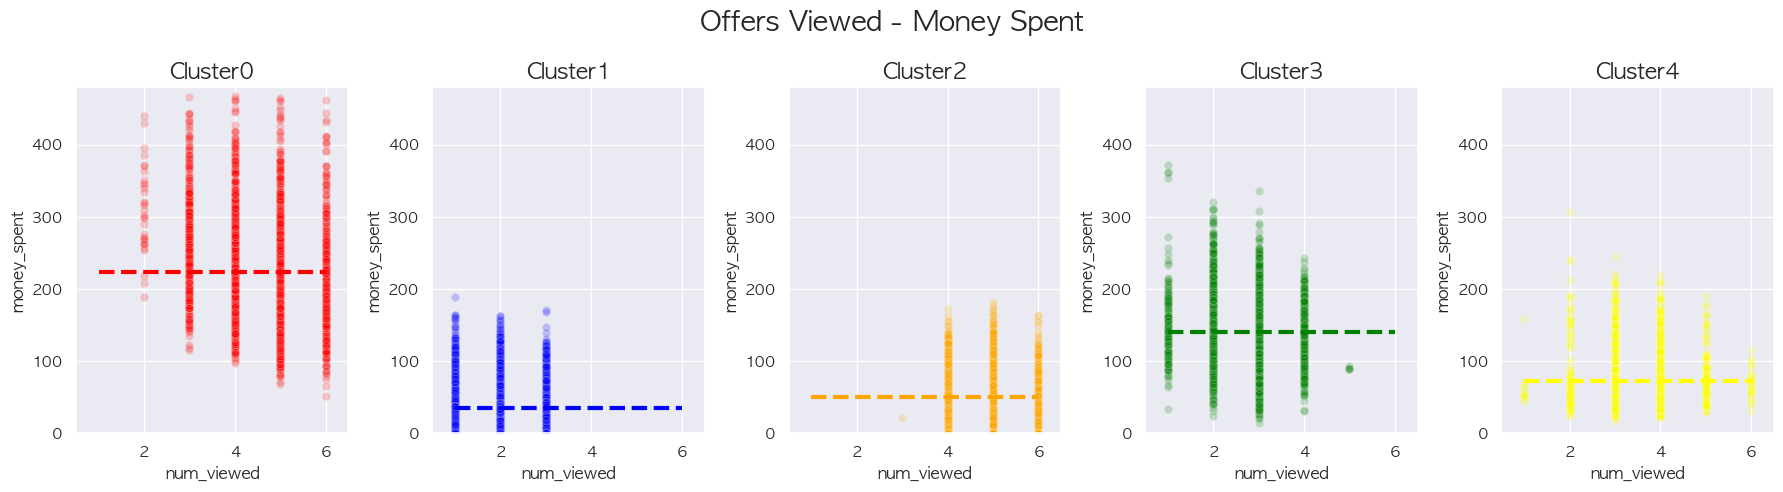

In [76]:
# offers viewed - money spent
fig, axes = plt.subplots(1, k, figsize=(18, 5))

for i in range(k):
  sns.scatterplot(
    data = customer_with_cluster[customer_with_cluster['cluster'] == i],
    x='num_viewed',
    y='money_spent',
    alpha=0.2,
    color=color_list[i],
    ax=axes[i])
    
  mean_value = customer_with_cluster[customer_with_cluster['cluster'] == i].agg({'money_spent': 'mean'})
  axes[i].plot(
    np.arange(1, 7),
    (np.ones((1, 6)) * mean_value.values).reshape((6,-1)), 
    color=color_list[i],
    lw=3,
    linestyle='dashed')
  
  axes[i].set_title('Cluster' + str(i), fontsize=16)
  axes[i].set_xlim((0.5, 6.5))
  axes[i].set_ylim((0, 480))

fig.suptitle('Offers Viewed - Money Spent', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show();

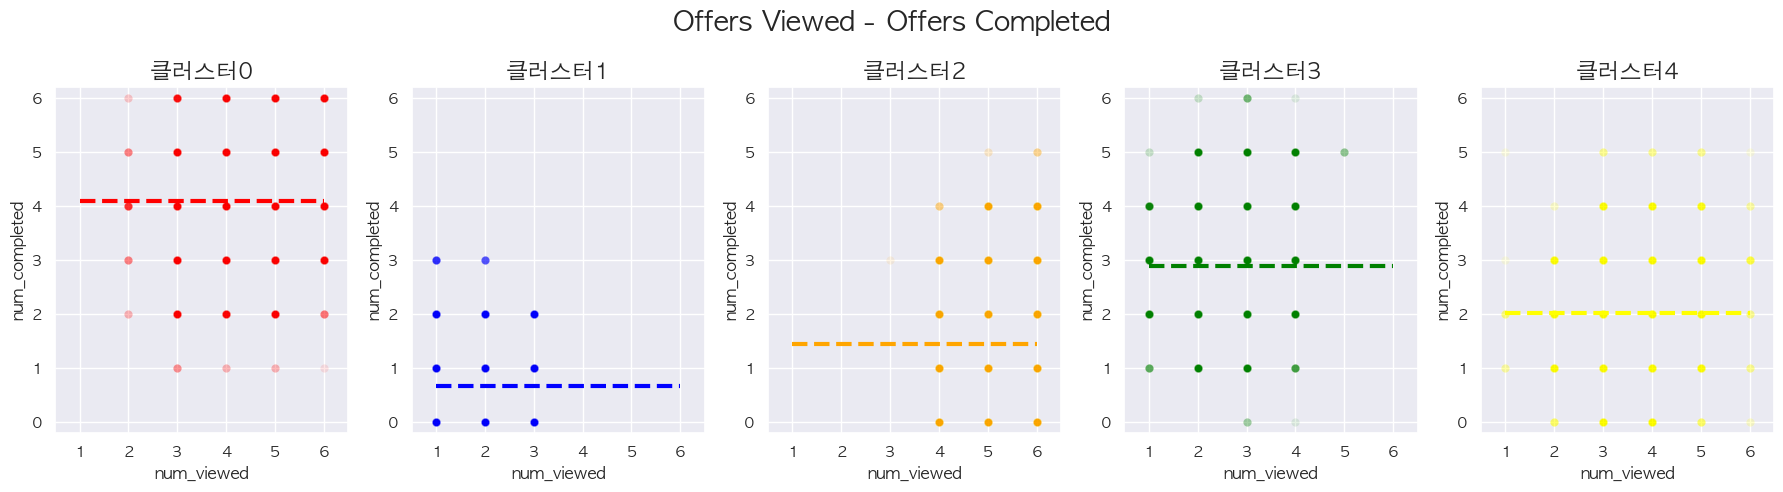

In [77]:
fig, axes = plt.subplots(1, k, figsize=(18, 5))

for i in range(k):
  sns.scatterplot(
    data=customer_with_cluster[customer_with_cluster['cluster'] == i],
    x='num_viewed',
    y='num_completed',
    alpha=0.1,
    color=color_list[i],
    ax=axes[i])
    
  mean_value = customer_with_cluster[customer_with_cluster['cluster'] == i].agg({'num_completed': 'mean'})
  axes[i].plot(
    np.arange(1, 7),
    (np.ones((1, 6))*mean_value.values).reshape((6,-1)), 
    color=color_list[i],
    lw=3,
    linestyle='dashed')
  axes[i].set_title('클러스터' + str(i), fontsize = 16)
  axes[i].set_xlim((0.5, 6.5))
  axes[i].set_ylim((-0.2, 6.2))

fig.suptitle('Offers Viewed - Offers Completed', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show();

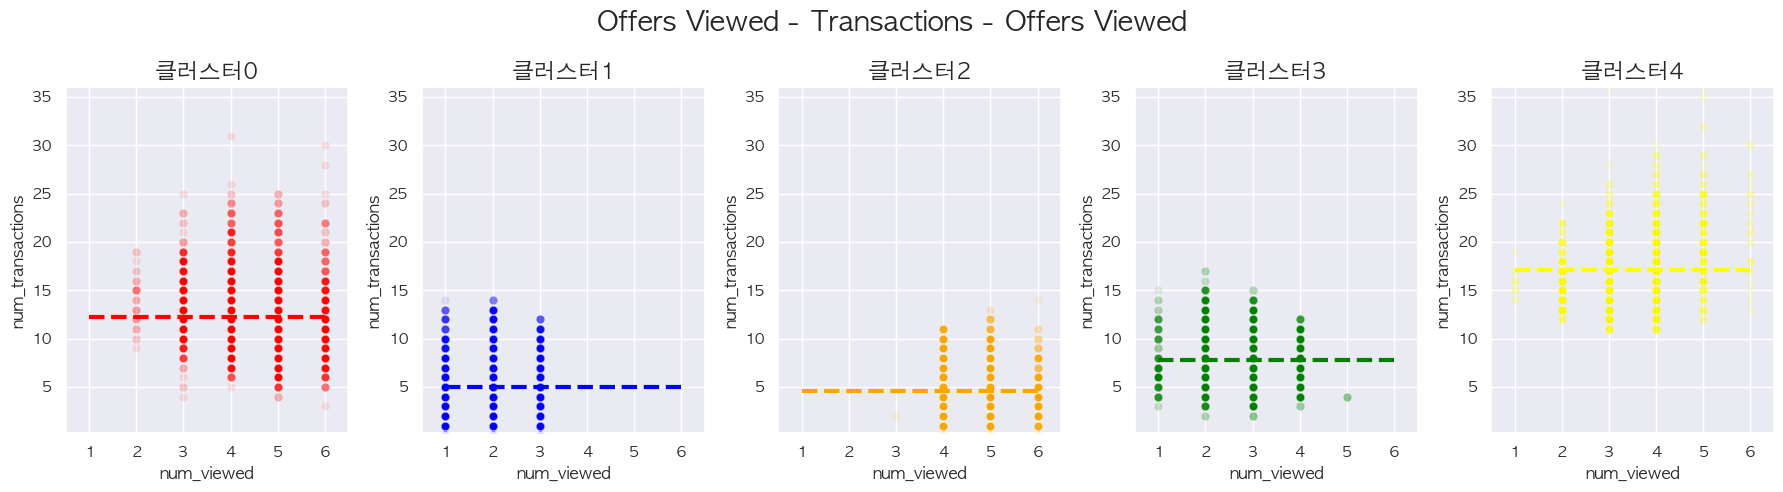

In [78]:
fig, axes = plt.subplots(1, k, figsize=(18,5))

for i in range(k):
  sns.scatterplot(
    data=customer_with_cluster[customer_with_cluster['cluster'] == i],
    x='num_viewed',
    y='num_transactions',
    alpha=0.1,
    color=color_list[i],
    ax=axes[i])
    
  mean_value = customer_with_cluster[customer_with_cluster['cluster'] == i].agg({'num_transactions': 'mean'})
  axes[i].plot(
    np.arange(1, 7),
    (np.ones((1, 6))*mean_value.values).reshape((6,-1)),
    color=color_list[i],
    lw=3,
    linestyle='dashed')
  axes[i].set_title('클러스터' + str(i), fontsize=16)
  axes[i].set_xlim((0.5, 6.5))
  axes[i].set_ylim((0.2, 36))

fig.suptitle('Offers Viewed - Transactions - Offers Viewed', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show();

/Users/jason/anaconda3/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/Users/jason/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


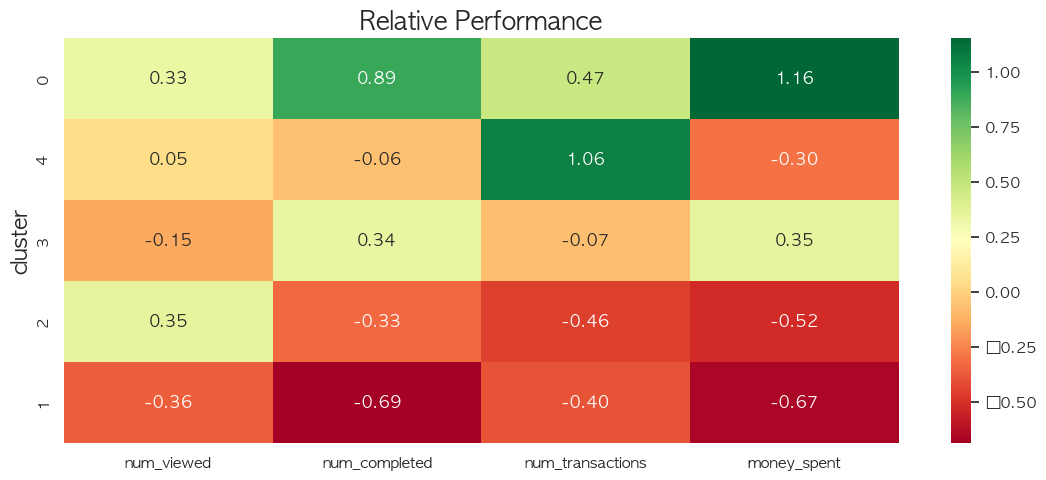

In [79]:
# 각 클러스터에 속한 고객의 performance를 측정 가능
cluster_mean = customer_with_cluster.groupby('cluster').mean()
population_mean = customer_with_cluster.mean()
relative_importance = (cluster_mean / population_mean[0 :-1]) - 1

importance_ranking = (
  relative_importance
    .sum(axis=1)
    .sort_values(ascending=False).index.values)
relative_importance = relative_importance.reindex(importance_ranking)

plt.figure(figsize=(12, k))
plt.title('Relative Performance', fontsize=18)
plt.xlabel('피쳐', fontsize=16)
plt.ylabel('클러스터', fontsize=16)
sns.heatmap(data=relative_importance, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();

#### 클러스터별 키 Metrics
1. Frequency: 실구매 횟수
2. APV(average purchase value): 평균 실구매 금액
3. Offer complete rate: Offer overall completion rate
4. Sensitivity to offer = (offer completed / 실구매 횟수)
5. ✅ 결론
  - Cluster 0(MVC; Most Valuable Customers)
    - offcer completed rate가 높다는 점에서 offer에 상당히 responsive하다고 볼 수 있다.
    - APV가 가장 높다.
    - 클러스터링 과정에서 제외한 상위 2% 고객들이 여기에 속한다.
    - ⭐️ 이 고객층이 이탈하지 않도록 해야 한다. 또한 이들의 지출 금액을 높이는 추가적인 프로모션을 기획할 필요성이 존재한다.
  - Cluster 4(Regulars)
    - 프로모션 기간 중 가장 빈번하게 구매한 고객층에 해당한다. (frequency)
    - offer-sensitive하지 않다. offer 없이도 구매한다는 특징을 유추할 수 있다.
    - APV는 그다지 높지 않다.
    - ⭐️ 별도의 offer 없이도 구매를 하는 고객층이기 때문에 조금 더 커스터마이징 된 전략이 필요해보인다. 고가의 제품을 체험하게 하거나 할인된 가격을 제공함으로써 APV 또한 높일 수 있는 방안이 필요하다.
  - Cluster 3(Potentials)
    - APV가 2번째로 높은 고객층이다.
    - offer complete rate 또한 2번째로 높다. 
    - 다른 고객층들에 비해 상대적으로 offer-sensitive하다.
    - ⭐️ 구매 빈도(frequency)가 높아진다면 MVC가 될 확률이 높은 고객층이다. offer-sensitive하다는 점을 통해 해당 고객들을 대상으로 다양한 프로모션 행사를 진행할 필요성이 존재한다.
  - Cluster 2(Offer-viewers)
    - offer를 클릭할 확률이 높은 고객층이기 때문에 이들을 대상으로 하는 전략으로, 다양한 프로모션을 제안하는 방안을 구사해야 한다.
  - Cluster 1(Low-engagers)
    - 예산이 허락하는 한에서 이들을 적극적인 고객으로 변환하는 전략이 필요하다. 하지만 데이터 상에서는 적극적인 고객으로 바뀔 가능성이 적어보인다.

In [80]:
temp = pd.merge(
  customer_with_cluster,
  customer_behavior_with_num_received['num_received'],
  left_index=True,
  right_index=True)
cluster_means = temp.groupby('cluster').mean().round(3)
cluster_means = cluster_means.reindex(importance_ranking)

cluster_means

,num_viewed,num_completed,num_transactions,money_spent,num_received
cluster,,,,,
0,4.455,4.093,12.247,223.588,5.094
4,3.509,2.029,17.087,72.383,4.671
3,2.861,2.902,7.735,140.087,4.160
2,4.543,1.453,4.523,50.083,5.032
1,2.143,0.675,4.996,34.730,3.879


In [81]:
# 클러스터 정보 요약을 위한 데이터프레임 생성
cluster_summary = pd.DataFrame(columns=['cluster', 'frequency', 'avg_purchase_value', 'offer_complete_rate', 'offer_sensitivity'])
cluster_summary['cluster'] = index = np.arange(k)
cluster_summary.set_index('cluster', drop=True, inplace=True)

cluster_summary['frequency'] = cluster_means['num_transactions'].round(1)
cluster_summary['avg_purchase_value'] = (cluster_means['money_spent'] / cluster_means['num_transactions']).round(1)
cluster_summary['offer_complete_rate'] = (cluster_means['num_completed'] / cluster_means['num_received']).round(2)
cluster_summary['offer_sensitivity'] = (cluster_means['num_completed'] / cluster_means['num_transactions']).round(2)

cluster_summary = cluster_summary.reindex(importance_ranking)
cluster_summary

,frequency,avg_purchase_value,offer_complete_rate,offer_sensitivity
cluster,,,,
0,12.2,18.3,0.80,0.33
4,17.1,4.2,0.43,0.12
3,7.7,18.1,0.70,0.38
2,4.5,11.1,0.29,0.32
1,5.0,7.0,0.17,0.14


#### 클러스터별 고객 특징

In [82]:
# K-평균 모델
money_spent_2pct_scaled = scaler_customer_behavior.transform(money_spent_2pct)

kmeans.predict(money_spent_2pct_scaled)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int3

In [83]:
cluster_kmeans = kmeans.predict(money_spent_2pct_scaled)
unique_element, counter = np.unique(cluster_kmeans, return_counts=True)

print('K-평균 모델에 의하면 상위 2% 고객들은 다음 클러스터에 속합니다: ')

for i in range(len(unique_element)):
    print('{}명의 고객들은 클러스터 {}에 속합니다.'.format(counter[i], unique_element[i]))

K-평균 모델에 의하면 상위 2% 고객들은 다음 클러스터에 속합니다: 
295명의 고객들은 클러스터 0에 속합니다.
2명의 고객들은 클러스터 3에 속합니다.


In [84]:
# 로지스틱회귀 모델
cluster_logistic = clf.predict(money_spent_2pct_scaled)
unique_element, counter = np.unique(cluster_logistic, return_counts=True)

print('로지스틱회귀 모델에 의하면 상위 2% 고객들은 다음 클러스터에 속합니다: ')
for i in range(len(unique_element)):
    print('{}명의 고객들은 클러스터 {}에 속합니다.'.format(counter[i], unique_element[i])) 

로지스틱회귀 모델에 의하면 상위 2% 고객들은 다음 클러스터에 속합니다: 
294명의 고객들은 클러스터 0에 속합니다.
3명의 고객들은 클러스터 3에 속합니다.


In [85]:
# KNN 모델
cluster_KNN = knn.predict(money_spent_2pct_scaled)
unique_element, counter = np.unique(cluster_KNN, return_counts=True)

print('KNN 모델에 의하면 상위 2% 고객들은 다음 클러스터에 속합니다: ')
for i in range(len(unique_element)):
    print('{}명의 고객들은 클러스터 {}에 속합니다.'.format(counter[i], unique_element[i])) 

KNN 모델에 의하면 상위 2% 고객들은 다음 클러스터에 속합니다: 
297명의 고객들은 클러스터 0에 속합니다.


In [86]:
customer_behavior_clustered = temp[money_spent_2pct.columns.values]
customer_behavior_clustered = customer_behavior_clustered.assign(cluster=temp['cluster'])
customer_behavior_clustered = pd.concat([customer_behavior_clustered, money_spent_2pct], axis=0)

customer_behavior_clustered.fillna(value=0, inplace=True)

customer_behavior_clustered['cluster'] = customer_behavior_clustered['cluster'].astype('int')

In [87]:
customer_behavior_clustered.reset_index(inplace=True)

customer_behavior_profile = (
  pd.merge(
    customer_behavior_clustered,
    customers,
    left_on='person',
    right_on = 'id').drop(['id'], axis=1))

# 고객군별 별칭 생성
customer_behavior_profile['cluster_alias'] = (
  customer_behavior_profile['cluster']
  .map({
    0: 'Most-Valuables',
    4: 'Regulars',
    3: 'High-Potentials',
    2: 'Offer-Viewers',
    1: 'Low-Engagers'}))

customer_behavior_profile.head(3)

,person,num_viewed,num_completed,num_transactions,money_spent,cluster,gender,age,became_member_on,income,age_group,income_group,cluster_alias
0,0009655768c64bdeb2e877511632db8f,4,3,8,127.60,3,M,33,2017-04-21,72000.0,26-35yrs,$60-75k,High-Potentials
1,0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46,2,O,40,2018-01-09,57000.0,36-45yrs,$45-60k,Offer-Viewers
2,0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86,3,F,59,2016-03-04,90000.0,56-65yrs,$75-90k,High-Potentials


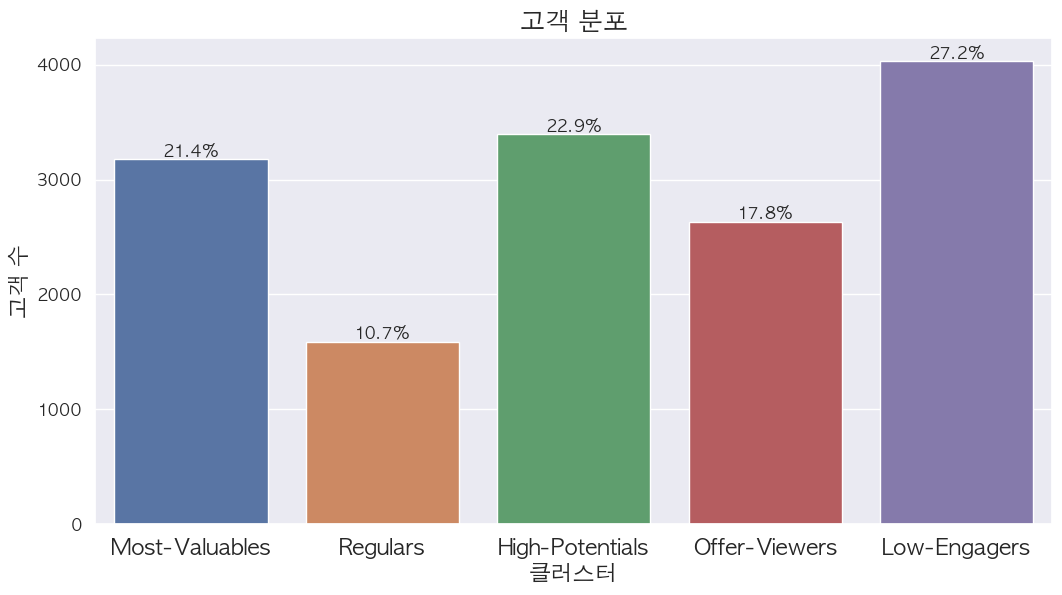

In [89]:
# 고객군별 고객 수
p = (
  customer_behavior_profile
    .value_counts('cluster')
    .reindex(importance_ranking)
)
cluster_pct = list((p/p.sum() * 100).round(2))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']

fig = plt.figure(figsize=(11, 6))
ax = sns.barplot(
  x=p.index.values,
  y=p.values,
  order=importance_ranking)

patches = ax.patches
for i in range(len(p)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height() + 25
    ax.annotate(
      text='{:.1f}%'.format(cluster_pct[i]),
      xy=(x, y),
      ha='center',
      fontsize=12, 
      weight='bold')
    
plt.title('고객 분포', fontsize=18)
plt.xticks(ticks=np.arange(len(p)), labels=cluster_names, fontsize=16)
plt.yticks(ticks=np.arange(0, 5000, 1000), fontsize=12)
plt.xlabel('클러스터', fontsize=16)
plt.ylabel('고객 수', fontsize=16)
plt.show();

In [90]:
# 고객군별 평균 나이/수입
segment_means = (
  customer_behavior_profile
    .groupby('cluster')
    .agg({'age': 'mean', 'income': 'mean'})
    .reindex(importance_ranking))
segment_means.index = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']

segment_means.round(2).head()

,age,income
Most-Valuables,56.04,71722.55
Regulars,47.33,48762.11
High-Potentials,57.99,74581.61
Offer-Viewers,55.53,65168.94
Low-Engagers,52.10,59408.04


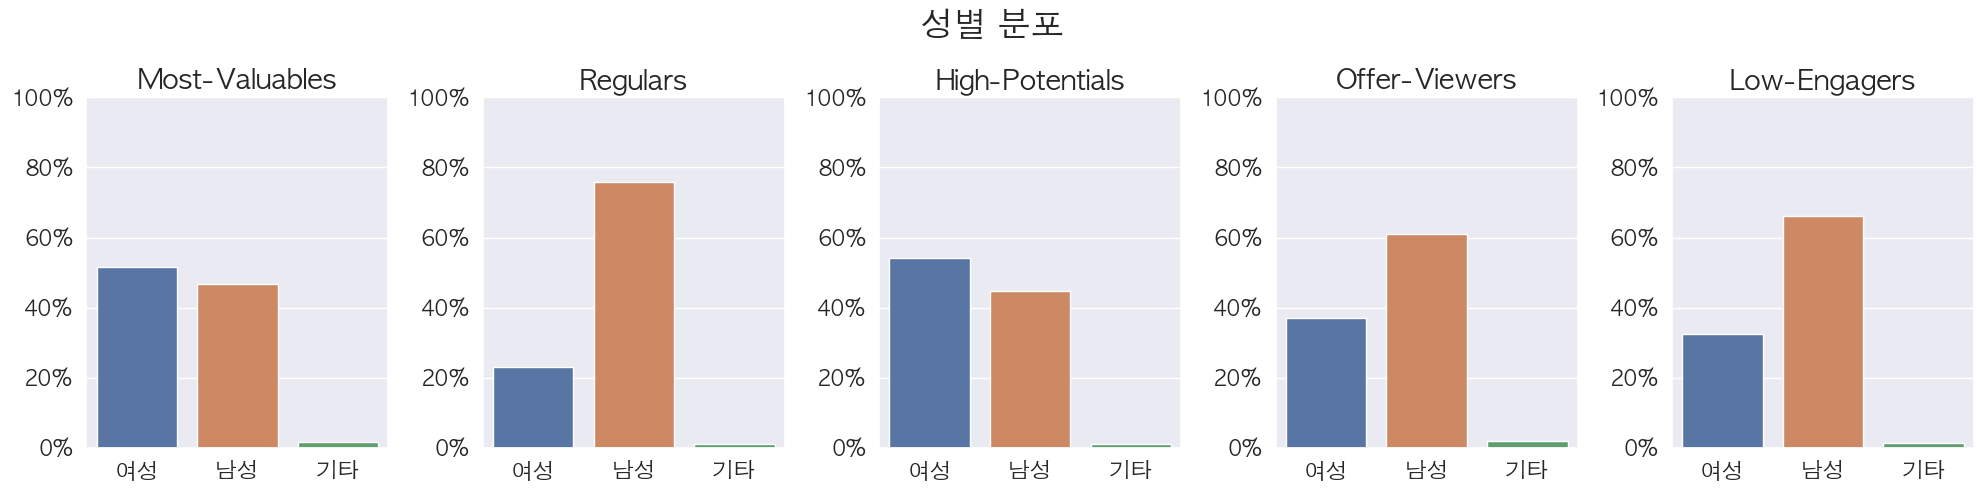

In [91]:
# 고객군별 성별 분포
num_clusters = customer_behavior_profile['cluster'].nunique()

fig, axes = plt.subplots(1, num_clusters, figsize=(20, 5))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
xticklabels = ['여성', '남성', '기타']
yticks = np.arange(0, 1.2, 0.2)
yticklabels = [str(n) + '%' for n in (yticks * 100).astype(int)]
for i in np.arange(num_clusters):
    p = (
      customer_behavior_profile[customer_behavior_profile['cluster'] == importance_ranking[i]]
        .value_counts('gender')
        .sort_index()
    )
    sns.barplot(
      x=p.index.values,
      y=p.values / p.sum(),
      ax=axes[i])
    axes[i].set_title(cluster_names[i], fontsize=20)
    axes[i].set_xticklabels(xticklabels, fontsize=16)
    axes[i].set_yticks(yticks); axes[i].set_yticklabels(yticklabels, fontsize=15)

plt.suptitle('성별 분포', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show();

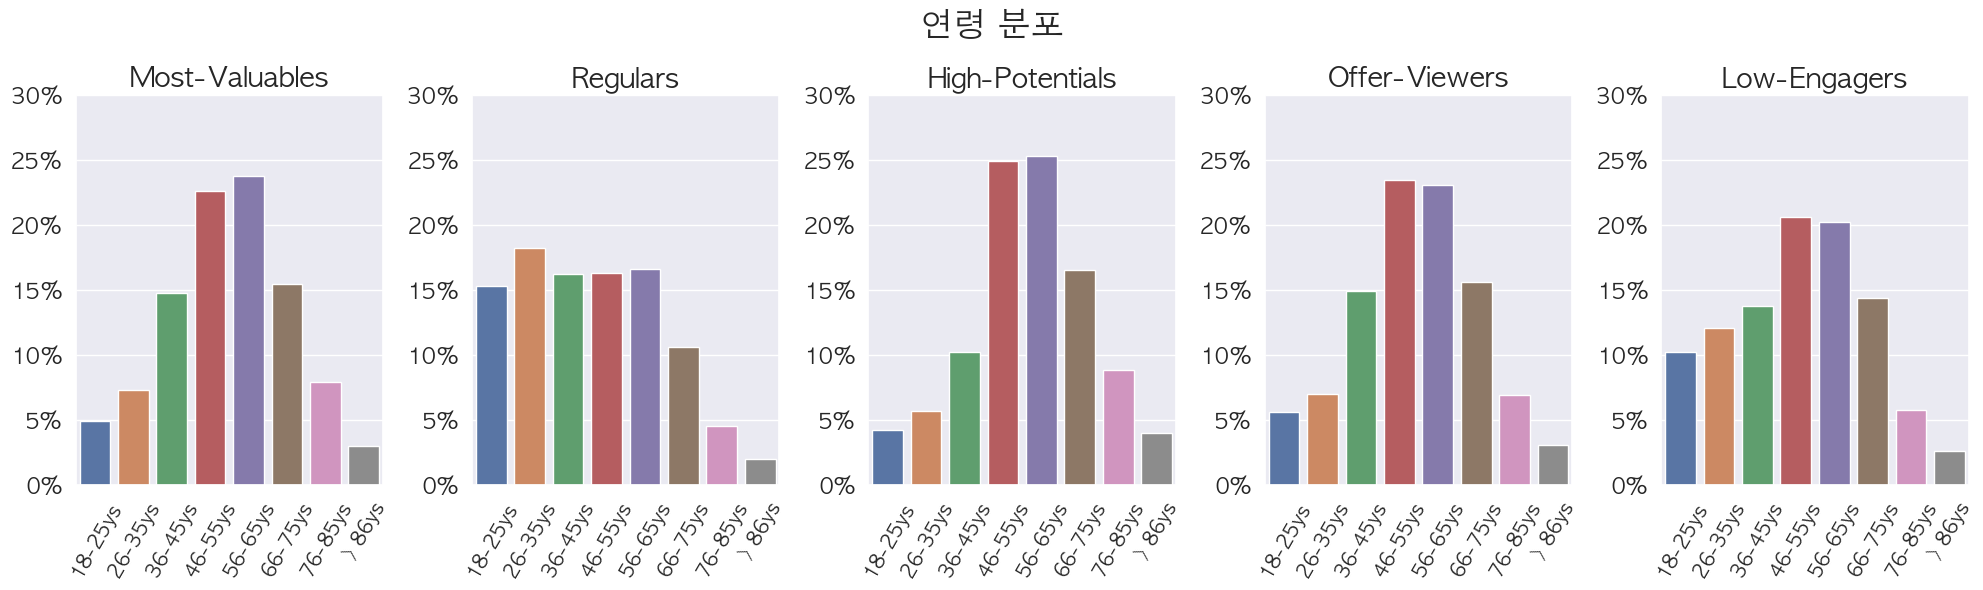

In [92]:
# 고객군별 연령 분포
fig, axes = plt.subplots(1, num_clusters, figsize=(20, 6))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
age_group_list = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys']
yticks = np.arange(0, 0.35, 0.05)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

for i in np.arange(num_clusters):
    p = (
      customer_behavior_profile[customer_behavior_profile['cluster'] == importance_ranking[i]]
        .value_counts('age_group')
        .sort_index()
    )
    sns.barplot(
      x=p.index.values,
      y=p.values / p.sum(),
      ax=axes[i])
    axes[i].set_title(cluster_names[i], fontsize=20)
    axes[i].set_yticks(yticks); axes[i].set_yticklabels(ytick_labels, fontsize=16)
    axes[i].set_xticklabels(age_group_list, rotation=60, fontsize=14)

plt.suptitle('연령 분포', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show();

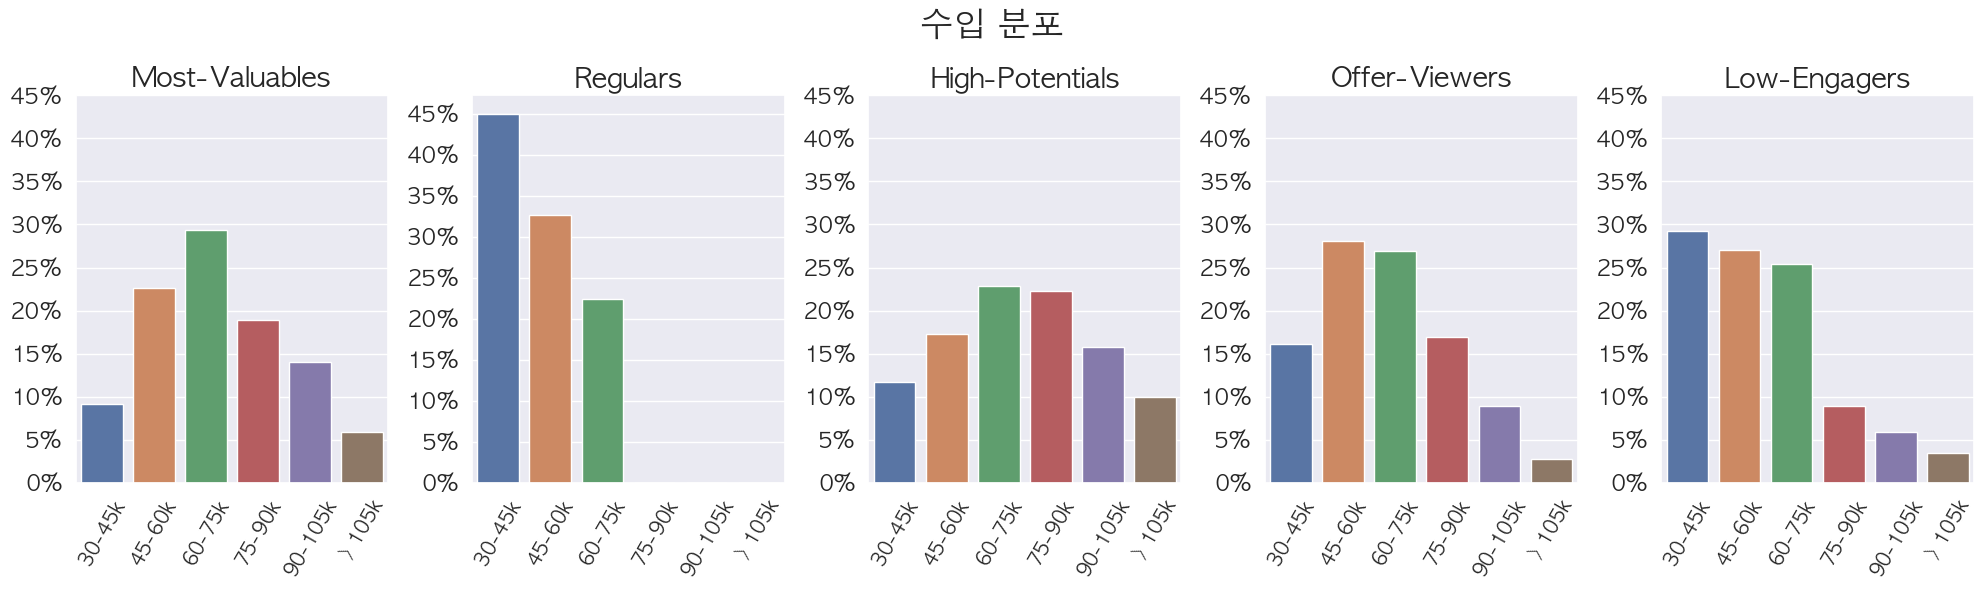

In [93]:
# 고객군별 수입 분포
fig, axes = plt.subplots(1, num_clusters, figsize=(20, 6))
cluster_names = ['Most-Valuables', 'Regulars', 'High-Potentials', 'Offer-Viewers', 'Low-Engagers']
income_group_list = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k']
yticks = np.arange(0, 0.5, 0.05)
ytick_labels = [str(n) + '%' for n in (yticks * 100).astype(int)]

for i in np.arange(num_clusters):
  p = (
    customer_behavior_profile[customer_behavior_profile['cluster'] == importance_ranking[i]]
      .value_counts('income_group')
      .sort_index()
  )
  sns.barplot(
    x=p.index.values,
    y=p.values / p.sum(),
    ax=axes[i])
  axes[i].set_title(cluster_names[i], fontsize=20)
  axes[i].set_yticks(yticks); axes[i].set_yticklabels(ytick_labels, fontsize=16)
  axes[i].set_xticklabels(income_group_list[: p.shape[0]], rotation=60, fontsize=14)

plt.suptitle('수입 분포', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show();